# Лабораторная работ №3 - "Подбор гиперпараметров модели" (ИНДИВИДУАЛЬНАЯ)

---

###### Выполнил: Дорофеев Демид Сергеевич
###### Группа: 307б
###### Датасет (ссылка): [Фондовый рынок](https://www.kaggle.com/datasets/prince7489/stock-market-dataset)

---

# Задание:

0. Выбрать модель для обучения (Desicion tree, Random forest, SVM, KNN, Boosting)
1. Показать какие гиперпараметры есть у выбранной модели (В виде таблички).
2. Выбрать датасет для обучения и взависимости от модели подготовить данные
3. Подобрать гиперпараметры для модели и сравнить лучшие подборы, для (Grid Search, RandomSearch, Optuna)
4. На самом лучшем обучении (Grid Search, RandomSearch, Optuna) сделать калькулятор, который показывает `локальную интерпретацию` с помощью [LIME](https://habr.com/ru/companies/otus/articles/779430/) и `глобальную интерпретацию` с помощью [SHAP](https://habr.com/ru/companies/ods/articles/599573/).

    [Доп статья](https://habr.com/ru/companies/wunderfund/articles/739744/)

# Датасеты на выбор (2 человека на датасет)

Нужно будет выбрать датасет и самим придумать задачу (регрессия или классификация)

* [Мошенические операции с картами](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
* [Фильмы](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata)
* [Рак молочной железы](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)
* [Кодвид](https://www.kaggle.com/datasets/imdevskp/corona-virus-report)
* [Футбол](https://www.kaggle.com/datasets/hugomathien/soccer)
* [Цена мобильных телефонов](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification)
* [120 лет Олимпийской истории](https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results)
* [Фитнесс](https://www.kaggle.com/datasets/arashnic/fitbit)
* [Употребление алкоголя студентами](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption)
* [Переносы рейсов самолетов](https://www.kaggle.com/datasets/usdot/flight-delays?select=flights.csv)
* [Покемоны](https://www.kaggle.com/datasets/abcsds/pokemon)
* [Формула 1](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020)
* [Набор данных сердечно сосудистых заболеваний](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset)
* [Spotify](https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023)
* [Качество воды](https://www.kaggle.com/datasets/adityakadiwal/water-potability)
* [Цена на машину](https://www.kaggle.com/datasets/hellbuoy/car-price-prediction)
* [Женщины и одежда](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)
* [Факторы успеваемости студентов](https://www.kaggle.com/datasets/lainguyn123/student-performance-factors)
* [Продукты](https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset)
* [Видео игры](https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset)
* [Машины](https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset)
* [BMW продажи](https://www.kaggle.com/datasets/ahmadrazakashif/bmw-worldwide-sales-records-20102024)
* [Землетрясения](https://www.kaggle.com/datasets/ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset)
* [Медицинские коляски](https://www.kaggle.com/datasets/jaderz/hospital-beds-management)
* [Фондовый рынок](https://www.kaggle.com/datasets/prince7489/stock-market-dataset)
* [Steam](https://www.kaggle.com/datasets/lunthu/steam-monthly-average-players)
* [Anime](https://www.kaggle.com/datasets/neelagiriaditya/anime-dataset-jan-1917-to-oct-2025)
* [YouTube](https://www.kaggle.com/datasets/neelagiriaditya/anime-dataset-jan-1917-to-oct-2025)
* [Электрички](https://www.kaggle.com/datasets/alamshihab075/electric-vehicle-population-dataset)


# Сроки

- до 17.11.25 оценка 5
- до 24.11.25 оценка 4

# Формат сдачи

1. Защита преподавателю
2. Презентация о проделанной работе (10-15 слайдов)
3. Файл `FIO_lr3.ibynb`

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_auc_score, roc_curve, auc
)

from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 34

lag_days = 0

In [2]:
# dataframe = pd.read_csv("random_stock_market_dataset.csv")
# dataframe = pd.read_csv("HistoricalQuotes.csv")
# dataframe = dataframe[::-1]
dataframe = pd.read_csv("Tesla.csv")
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1692 non-null   object 
 1   Open      1692 non-null   float64
 2   High      1692 non-null   float64
 3   Low       1692 non-null   float64
 4   Close     1692 non-null   float64
 5   Volume    1692 non-null   int64  
 6   AdjClose  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


In [3]:
# Создание признаков и целевой переменной
def prepare_data(df: pd.DataFrame, lag_days=10) -> pd.DataFrame:
    data = df.copy()
    
    # Лаги для всех признаков
    if lag_days!=0:
        for i in range(1, lag_days + 1):
            data_copy = data.copy()
            data[f'Close_lag_{i}'] = data_copy['Close'].shift(i)
            data[f'Volume_lag_{i}'] = data_copy['Volume'].shift(i)
            data[f'High_lag_{i}'] = data_copy['High'].shift(i)
            data[f'Low_lag_{i}'] = data_copy['Low'].shift(i)
    
    data_copy = data.copy()
    # Технические индикаторы
    data['Price_Range'] = data['High'] - data['Low']
    data['Price_Momentum'] = data['Close'] - data_copy['Close'].shift(3)
    
    # Целевая переменная для регрессии
    data['Next_Close'] = data['Close'].shift(-1)
    
    # Целевая переменная для классификации (будет вычислена позже)
    data['Next_Direction'] = (data['Next_Close'] > data['Close']).astype(int)
    
    return data.dropna()

# Подготовка данных

prepared_data = prepare_data(dataframe, lag_days=lag_days)

# del prepared_data['High']
# del prepared_data['Low']
# del prepared_data['Price_Range']
# del prepared_data['Price_Momentum']

try:
    del prepared_data['AdjClose']
except:
    pass

prepared_data.head(5)

Date       Open       High        Low      Close   Volume  Price_Range  \
3  7/2/2010  23.000000  23.100000  18.709999  19.200001  5139800     4.390001   
4  7/6/2010  20.000000  20.000000  15.830000  16.110001  6866900     4.170000   
5  7/7/2010  16.400000  16.629999  14.980000  15.800000  6921700     1.649999   
6  7/8/2010  16.139999  17.520000  15.570000  17.459999  7711400     1.950000   
7  7/9/2010  17.580000  17.900000  16.549999  17.400000  4050600     1.350001   

   Price_Momentum  Next_Close  Next_Direction  
3       -4.689998   16.110001               0  
4       -7.719999   15.800000               0  
5       -6.159999   17.459999               1  
6       -1.740002   17.400000               0  
7        1.289999   17.049999               0

#### 2.3.2. Создание методов для отрисовки и обработки данных

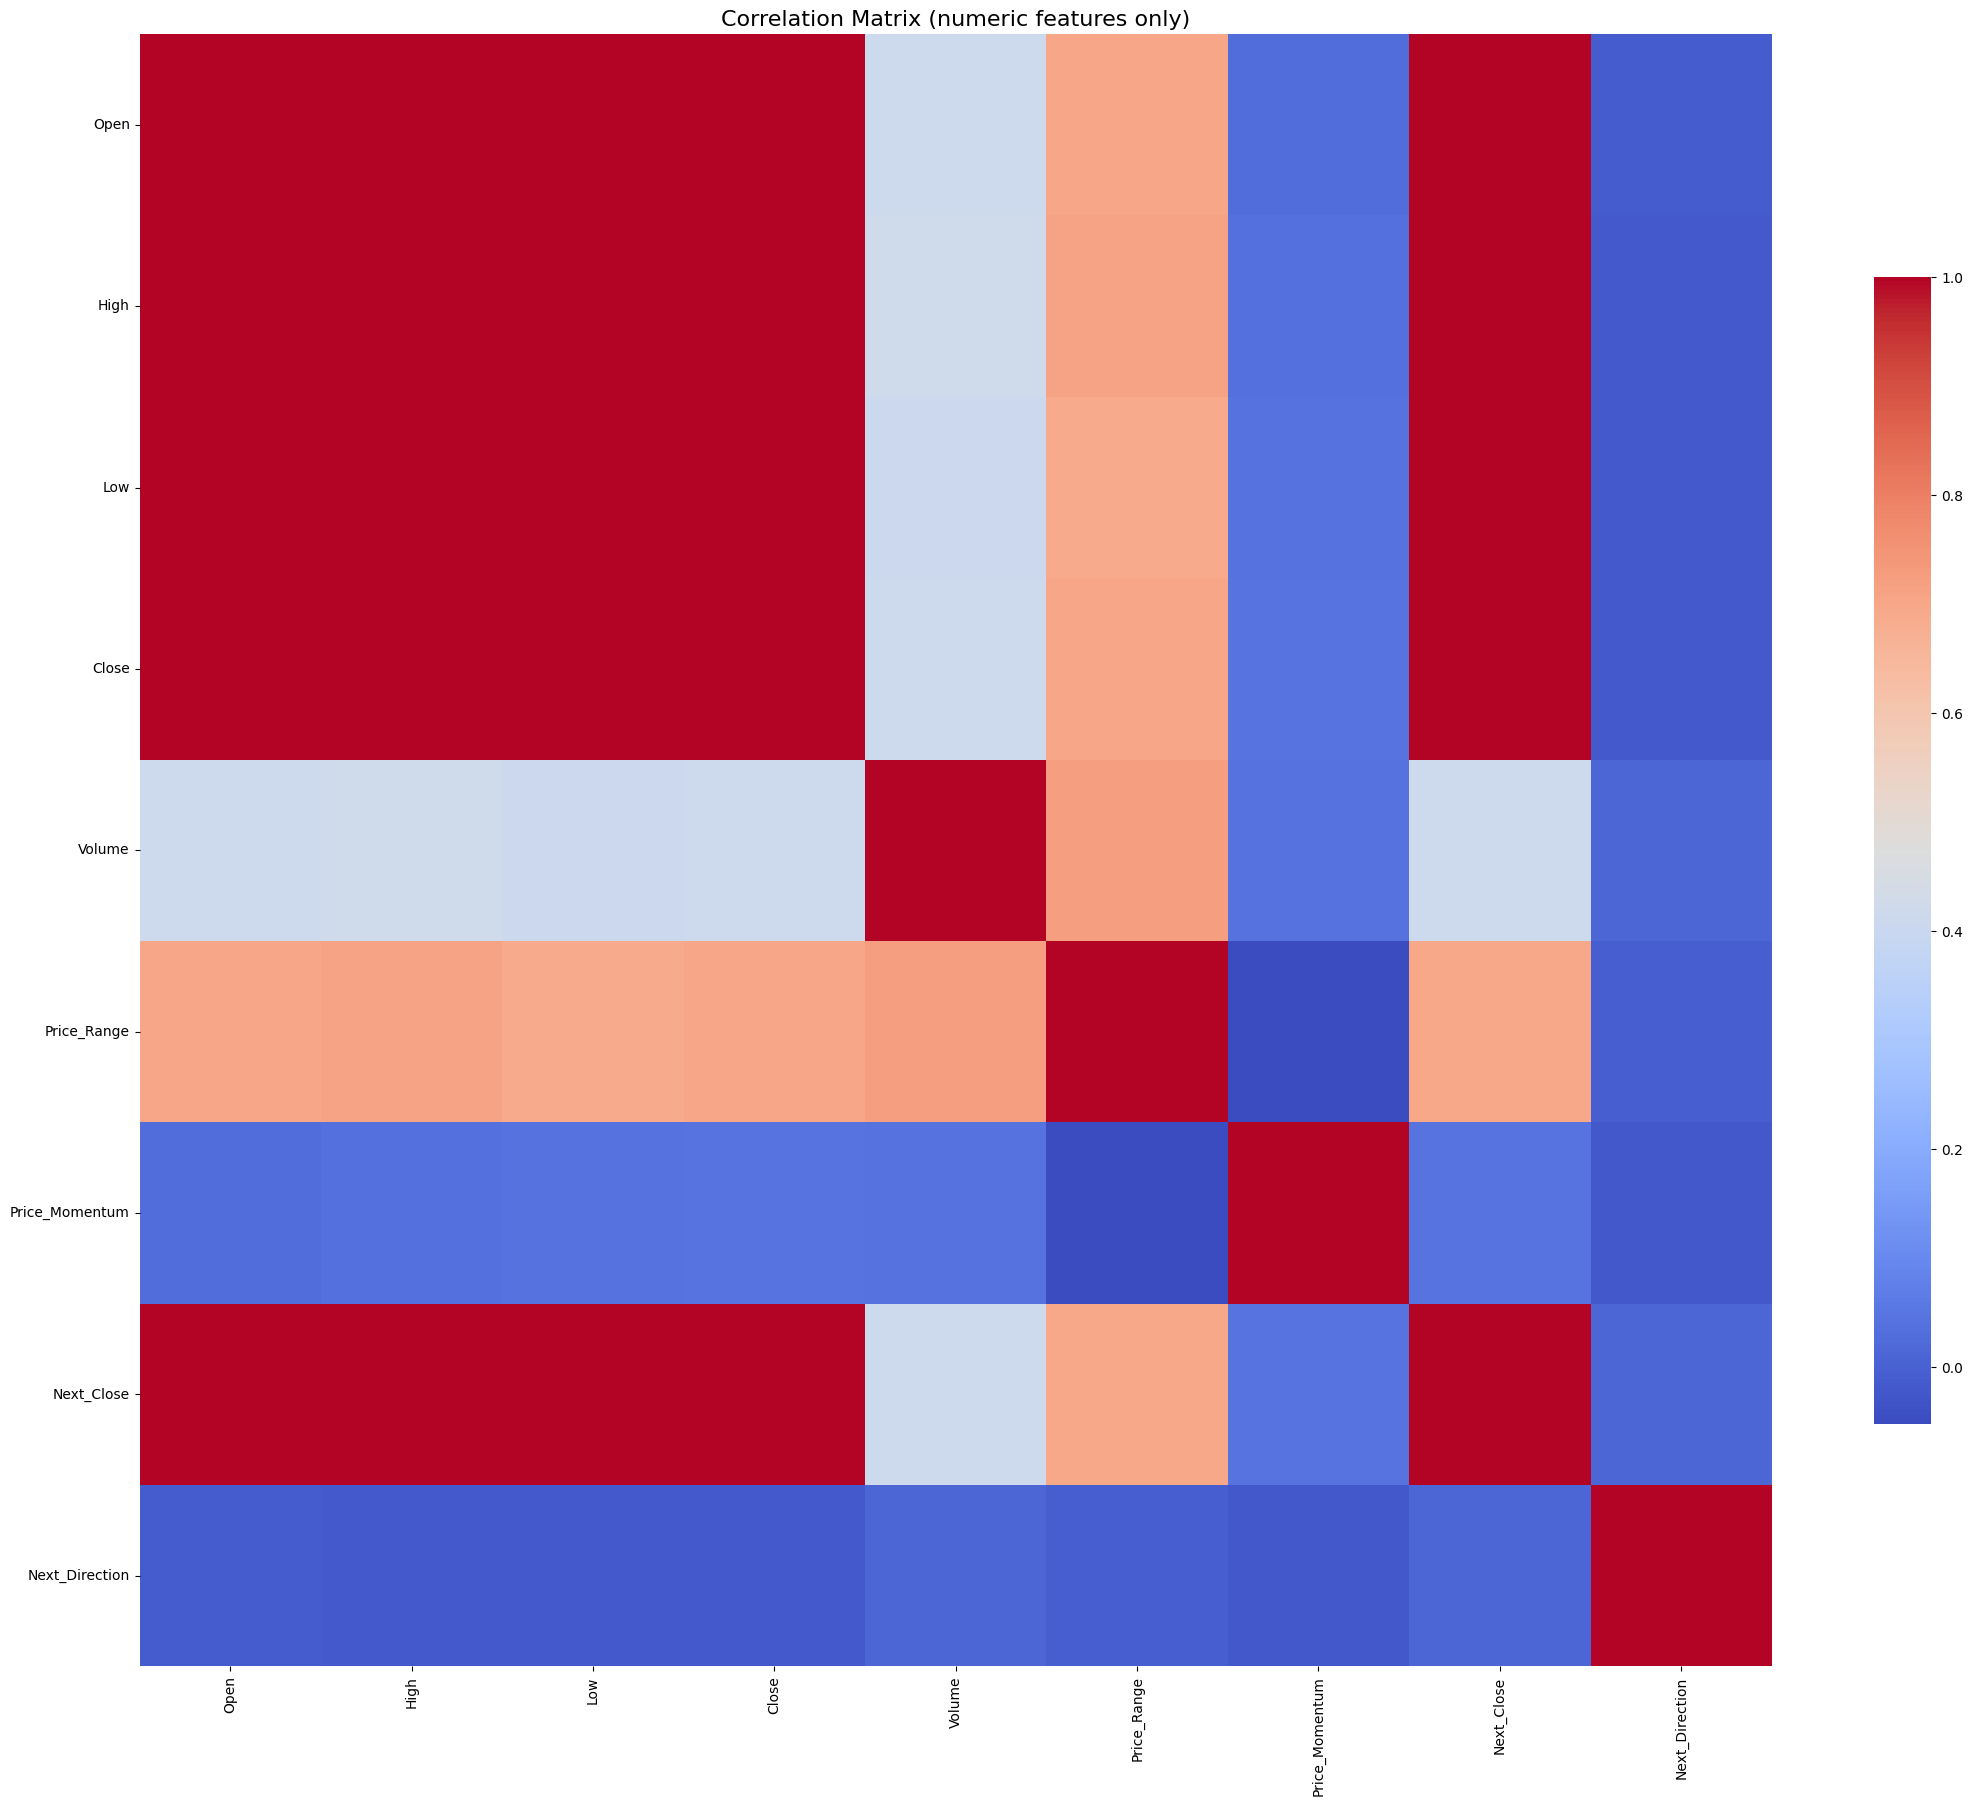

count          mean           std            min  \
Open            1688.0  1.325577e+02  9.425478e+01      16.139999   
High            1688.0  1.348837e+02  9.564775e+01      16.629999   
Low             1688.0  1.301133e+02  9.279514e+01      14.980000   
Close           1688.0  1.325463e+02  9.426012e+01      15.800000   
Volume          1688.0  4.250856e+06  4.273542e+06  118500.000000   
Price_Range     1688.0  4.770355e+00  4.074247e+00       0.250000   
Price_Momentum  1688.0  4.183057e-01  7.762205e+00     -38.860001   
Next_Close      1688.0  1.326898e+02  9.427190e+01      15.800000   
Next_Direction  1688.0  5.130332e-01  4.999782e-01       0.000000   

                         25%           50%           75%           max  
Open            3.000000e+01  1.570500e+02  2.205575e+02  2.876700e+02  
High            3.073250e+01  1.626950e+02  2.241000e+02  2.914200e+02  
Low             2.925500e+01  1.537050e+02  2.171200e+02  2.804000e+02  
Close           2.993250e+01  1.595800e+02  2.200225e+02  2.860400e+02  
Volume          1.192750e+06  3.174650e+06  5.635425e+06  3.716390e+07  
Price_Range     1.240000e+00  4.130005e+00  7.035000e+00  3.639999e+01  
Price_Momentum -1.802501e+00  2.699995e-01  3.094999e+00  4.339999e+01  
Next_Close      2.994750e+01  1.603200e+02  2.200650e+02  2.860400e+02  
Next_Direction  0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def draw_corr_matrix(df):
    corr = df.select_dtypes(include=['number']).corr()
    corr = corr.dropna(how="all", axis=0).dropna(how="all", axis=1)

    plt.figure(figsize=(22, 18))
    sns.heatmap(
        corr,
        annot=False,
        cmap="coolwarm",
        square=True,
        cbar_kws={"shrink": .7}
    )
    plt.title("Correlation Matrix (numeric features only)", fontsize=16)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()


# example
draw_corr_matrix(prepared_data)
prepared_data.describe().T

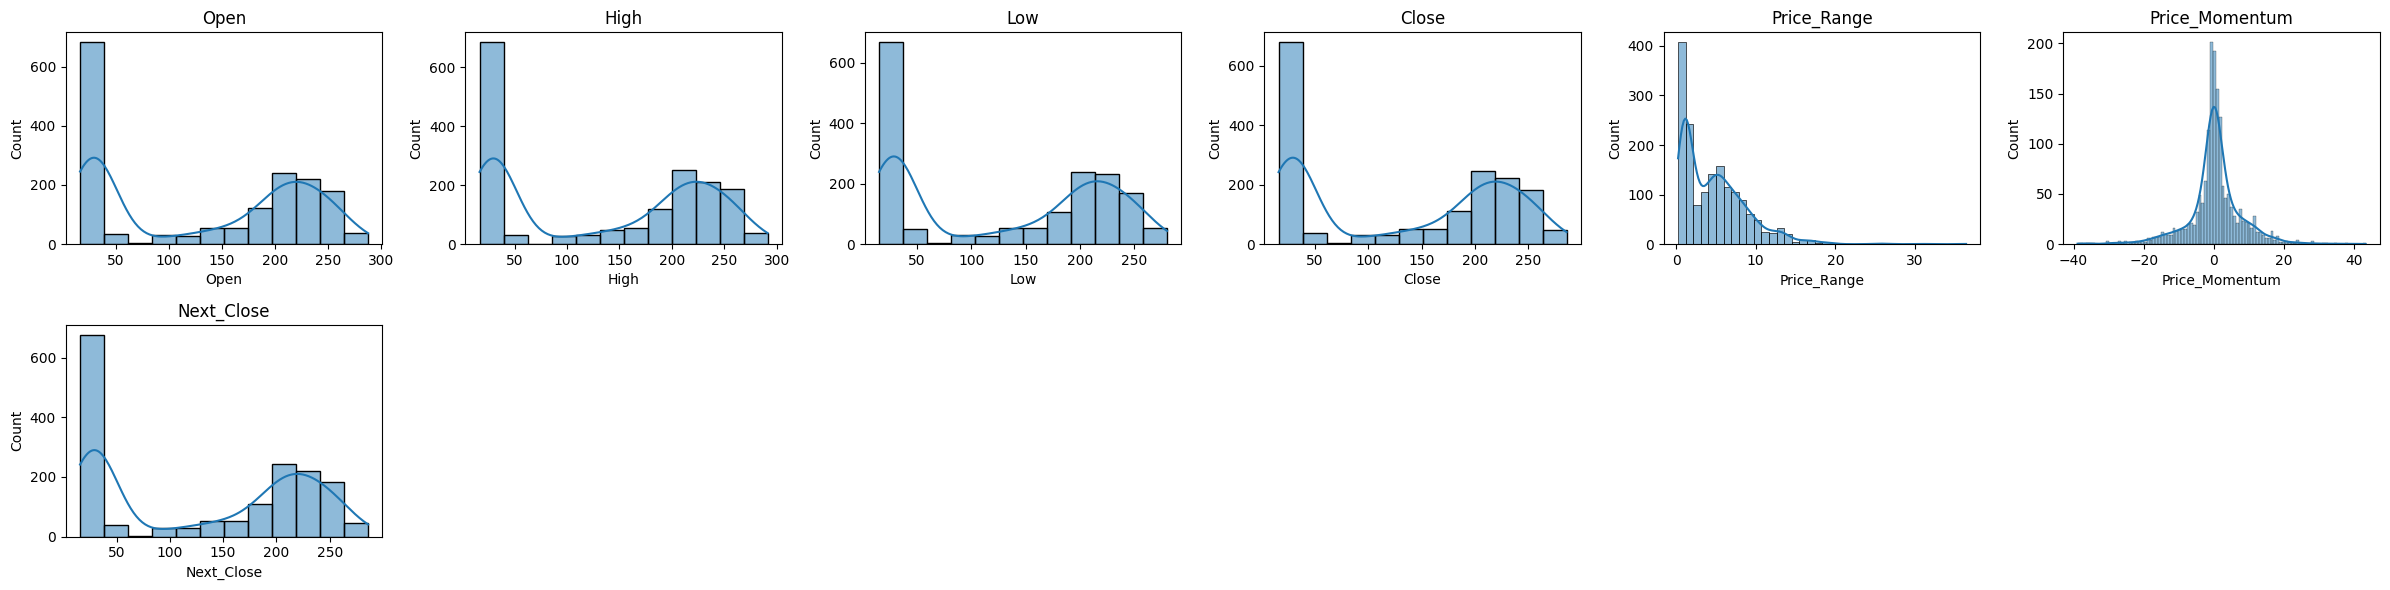

count          mean           std            min  \
Open            1688.0  1.325577e+02  9.425478e+01      16.139999   
High            1688.0  1.348837e+02  9.564775e+01      16.629999   
Low             1688.0  1.301133e+02  9.279514e+01      14.980000   
Close           1688.0  1.325463e+02  9.426012e+01      15.800000   
Volume          1688.0  4.250856e+06  4.273542e+06  118500.000000   
Price_Range     1688.0  4.770355e+00  4.074247e+00       0.250000   
Price_Momentum  1688.0  4.183057e-01  7.762205e+00     -38.860001   
Next_Close      1688.0  1.326898e+02  9.427190e+01      15.800000   
Next_Direction  1688.0  5.130332e-01  4.999782e-01       0.000000   

                         25%           50%           75%           max  
Open            3.000000e+01  1.570500e+02  2.205575e+02  2.876700e+02  
High            3.073250e+01  1.626950e+02  2.241000e+02  2.914200e+02  
Low             2.925500e+01  1.537050e+02  2.171200e+02  2.804000e+02  
Close           2.993250e+01  1.595800e+02  2.200225e+02  2.860400e+02  
Volume          1.192750e+06  3.174650e+06  5.635425e+06  3.716390e+07  
Price_Range     1.240000e+00  4.130005e+00  7.035000e+00  3.639999e+01  
Price_Momentum -1.802501e+00  2.699995e-01  3.094999e+00  4.339999e+01  
Next_Close      2.994750e+01  1.603200e+02  2.200650e+02  2.860400e+02  
Next_Direction  0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00

In [5]:
def draw_hist(df: pd.DataFrame, n_cols=6):
    float_cols = df.select_dtypes(include='float').columns
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()  # делаем одномерным массивом для удобства

    for i, col in enumerate(float_cols):
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'{col}')

    # Если графиков меньше, чем ячеек в сетке, скрываем лишние
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_hist(prepared_data)
prepared_data.describe().T

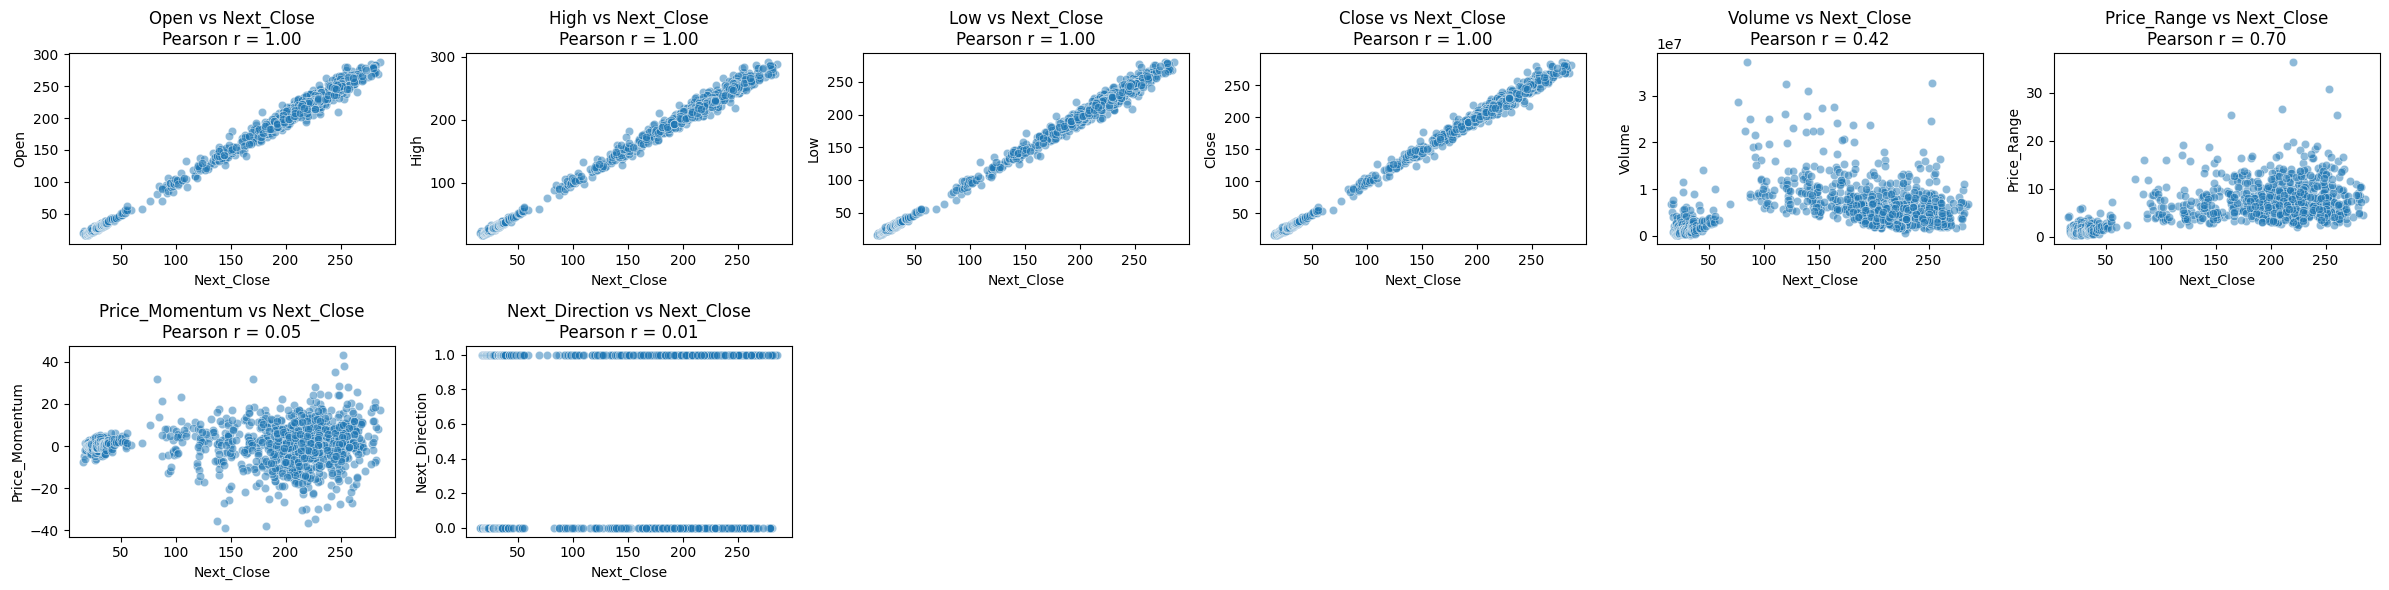

count          mean           std            min  \
Open            1688.0  1.325577e+02  9.425478e+01      16.139999   
High            1688.0  1.348837e+02  9.564775e+01      16.629999   
Low             1688.0  1.301133e+02  9.279514e+01      14.980000   
Close           1688.0  1.325463e+02  9.426012e+01      15.800000   
Volume          1688.0  4.250856e+06  4.273542e+06  118500.000000   
Price_Range     1688.0  4.770355e+00  4.074247e+00       0.250000   
Price_Momentum  1688.0  4.183057e-01  7.762205e+00     -38.860001   
Next_Close      1688.0  1.326898e+02  9.427190e+01      15.800000   
Next_Direction  1688.0  5.130332e-01  4.999782e-01       0.000000   

                         25%           50%           75%           max  
Open            3.000000e+01  1.570500e+02  2.205575e+02  2.876700e+02  
High            3.073250e+01  1.626950e+02  2.241000e+02  2.914200e+02  
Low             2.925500e+01  1.537050e+02  2.171200e+02  2.804000e+02  
Close           2.993250e+01  1.595800e+02  2.200225e+02  2.860400e+02  
Volume          1.192750e+06  3.174650e+06  5.635425e+06  3.716390e+07  
Price_Range     1.240000e+00  4.130005e+00  7.035000e+00  3.639999e+01  
Price_Momentum -1.802501e+00  2.699995e-01  3.094999e+00  4.339999e+01  
Next_Close      2.994750e+01  1.603200e+02  2.200650e+02  2.860400e+02  
Next_Direction  0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00

In [6]:
def draw_scatter_vs_target(df: pd.DataFrame, target: str, n_cols=6):
    float_cols = df.select_dtypes(include=['float', 'int']).columns.drop(target)
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()

    for i, col in enumerate(float_cols):
        sns.scatterplot(x=target, y=col, data=df, ax=axs[i], alpha=0.5)

        # коэффициент корреляции Пирсона
        corr = df[col].corr(df[target], method='pearson')
        axs[i].set_title(f'{col} vs {target}\nPearson r = {corr:.2f}')

    # скрываем лишние пустые ячейки
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_scatter_vs_target(prepared_data, target="Next_Close")
prepared_data.describe().T

In [7]:
# Сортируем данные по Date перед разделением
# prepared_data = prepared_data.sort_values('Date')

# Разделение на признаки и цели
features = [col for col in prepared_data.columns if col not in ['Next_Close', 'Next_Direction', 'Date']]
features = [col for col in prepared_data.columns if col not in ['Next_Close', 'Next_Direction', 'Date']]
X = prepared_data[features]
y = prepared_data['Next_Close']  # Для регрессии

# Временное разделение
train_size = int(0.5 * len(X))

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]



# # стандартное разделение
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=RANDOM_STATE
# )


# Проверка корректности сортировки
# print("Проверка временного порядка:")
# print(f"Первая дата в train: {prepared_data['Date'].iloc[0]}")
# print(f"Последняя дата в train: {prepared_data['Date'].iloc[train_size-1]}")
# print(f"Первая дата в test: {prepared_data['Date'].iloc[train_size]}")
# print(f"Последняя дата в test: {prepared_data['Date'].iloc[-1]}")

X_train.describe()

Open        High         Low       Close        Volume  \
count  844.000000  844.000000  844.000000  844.000000  8.440000e+02   
mean    45.859988   46.891813   44.736955   45.853104  2.938910e+06   
std     41.654983   42.596095   40.589918   41.695100  4.547404e+06   
min     16.139999   16.629999   14.980000   15.800000  1.185000e+05   
25%     26.697501   27.107499   25.959999   26.500000  7.776500e+05   
50%     30.000000   30.724999   29.250000   29.925000  1.193900e+06   
75%     35.259998   35.905000   34.622498   35.207499  2.517075e+06   
max    193.960007  194.500000  188.369995  193.369995  3.716390e+07   

       Price_Range  Price_Momentum  
count   844.000000      844.000000  
mean      2.154858        0.513614  
std       2.540371        3.818954  
min       0.250000      -20.059997  
25%       0.870001       -0.832501  
50%       1.239999        0.235000  
75%       2.039999        1.549999  
max      19.019997       32.010002

#### Random Forest Classifier (Случайный лес)

**Случайный лес — краткое пояснение:**

Случайный лес — это ансамблевый метод машинного обучения, основанный на **множестве деревьев решений**, каждое из которых обучается независимо на случайных подвыборках данных и признаков.
Модель объединяет результаты всех деревьев (обычно **путём голосования**) для получения более устойчивого и точного предсказания.

Идея метода:
Вместо одного дерева (которое может переобучаться), алгоритм строит **множество случайных деревьев**, каждое из которых "смотрит" на разные части данных.
В результате снижается разброс модели и повышается обобщающая способность.

Основные шаги:

1. Из исходных данных случайно выбираются подмножества объектов (методом *bootstrap*).
2. Для каждого дерева случайно выбирается подмножество признаков.
3. Каждое дерево строится независимо, как обычное дерево решений.
4. При классификации итоговый класс выбирается **по большинству голосов деревьев**.

Преимущества:

* Устойчив к переобучению.
* Хорошо работает “из коробки” без сильной настройки параметров.
* Может оценивать важность признаков (*feature importance*).

Недостатки:

* Менее интерпретируем, чем одно дерево.
* Медленнее при очень больших данных.


In [8]:
from sklearn.ensemble import RandomForestRegressor

model_forest = RandomForestRegressor(
    n_estimators=500,        # Количество деревьев в лесе.
                             # Большее число деревьев обычно улучшает качество, но увеличивает время обучения.
                             # Варианты: 50, 100, 200, 500.

    criterion='squared_error', # Критерий качества разбиений для каждого дерева.
                             # 'squared_error' — среднеквадратичная ошибка (по умолчанию),
                             # 'absolute_error' — средняя абсолютная ошибка,
                             # 'poisson' — для данных с распределением Пуассона.

    max_depth=10,            # Максимальная глубина каждого дерева.
                             # None — без ограничения (может переобучаться).
                             # Примеры: 5, 10, 20.

    min_samples_split=5,     # Минимальное количество образцов для разбиения узла.
                             # Увеличение уменьшает переобучение.

    min_samples_leaf=5,      # Минимальное количество образцов в листе.
                             # Увеличение делает модель более "плавной".

    max_features=1.0,        # Количество признаков, используемых при поиске лучшего разбиения.
                             # 1.0 — использовать все признаки (стандарт для регрессии),
                             # 'sqrt' — корень из числа признаков,
                             # 'log2' — логарифм по основанию 2, или число/доля признаков.

    bootstrap=True,          # Использовать ли bootstrap-подвыборки при обучении деревьев.
                             # True — стандартный вариант, False — использовать все данные.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    n_jobs=None,             # Количество потоков.
                             # None — одно ядро, -1 — использовать все ядра процессора.

    min_impurity_decrease=0.0, # Минимальное уменьшение примеси для разбиения.
    
    ccp_alpha=0.0           # Параметр минимальной cost-complexity pruning.
)

In [9]:
model_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=500, random_state=34)

**Как интерпретировать**

| Метрика | Как читать                    | Что значит для анализа                                                   |
| ------- | ----------------------------- | ------------------------------------------------------------------------ |
| MSE     | Чем меньше, тем точнее        | Показывает среднюю квадратичную ошибку. Выбросы сильно влияют.           |
| RMSE    | В тех же единицах, что и цель | Удобно для прямой интерпретации ошибок.                                  |
| MAE     | Средняя абсолютная ошибка     | Устойчивее к выбросам, показывает среднюю фактическую ошибку.            |
| R²      | 0–1 (или <0)                  | 1 — идеальное совпадение, 0 — предсказывает среднее, <0 — хуже среднего. |

In [10]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

def get_metrics_regression(y_true, y_pred):
    return {
        'MSE': mse(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'R2': r2(y_true, y_pred)
    }

In [11]:
predicted_prices_forest = model_forest.predict(X_test)

get_metrics_regression(y_test, predicted_prices_forest)

{'MSE': np.float64(2071.3139221857964),
 'RMSE': np.float64(45.5116899508884),
 'MAE': np.float64(38.18883340675601),
 'R2': np.float64(-1.100309895711808)}

In [12]:
def average_numpy_array(arr, n):
    # Оставляем только полные группы
    truncated_len = len(arr) // n * n
    if truncated_len == 0:
        return arr
    
    truncated_arr = arr[:truncated_len]
    # Переформатируем и вычисляем среднее
    return truncated_arr.reshape(-1, n).mean(axis=1)

def sample_every_n(arr, n):
    """
    Оставляет каждое n-е значение из массива
    
    Parameters:
    arr: numpy array или list
    n: шаг выборки
    
    Returns:
    Массив с каждым n-м элементом
    """
    return arr.copy()[::n]



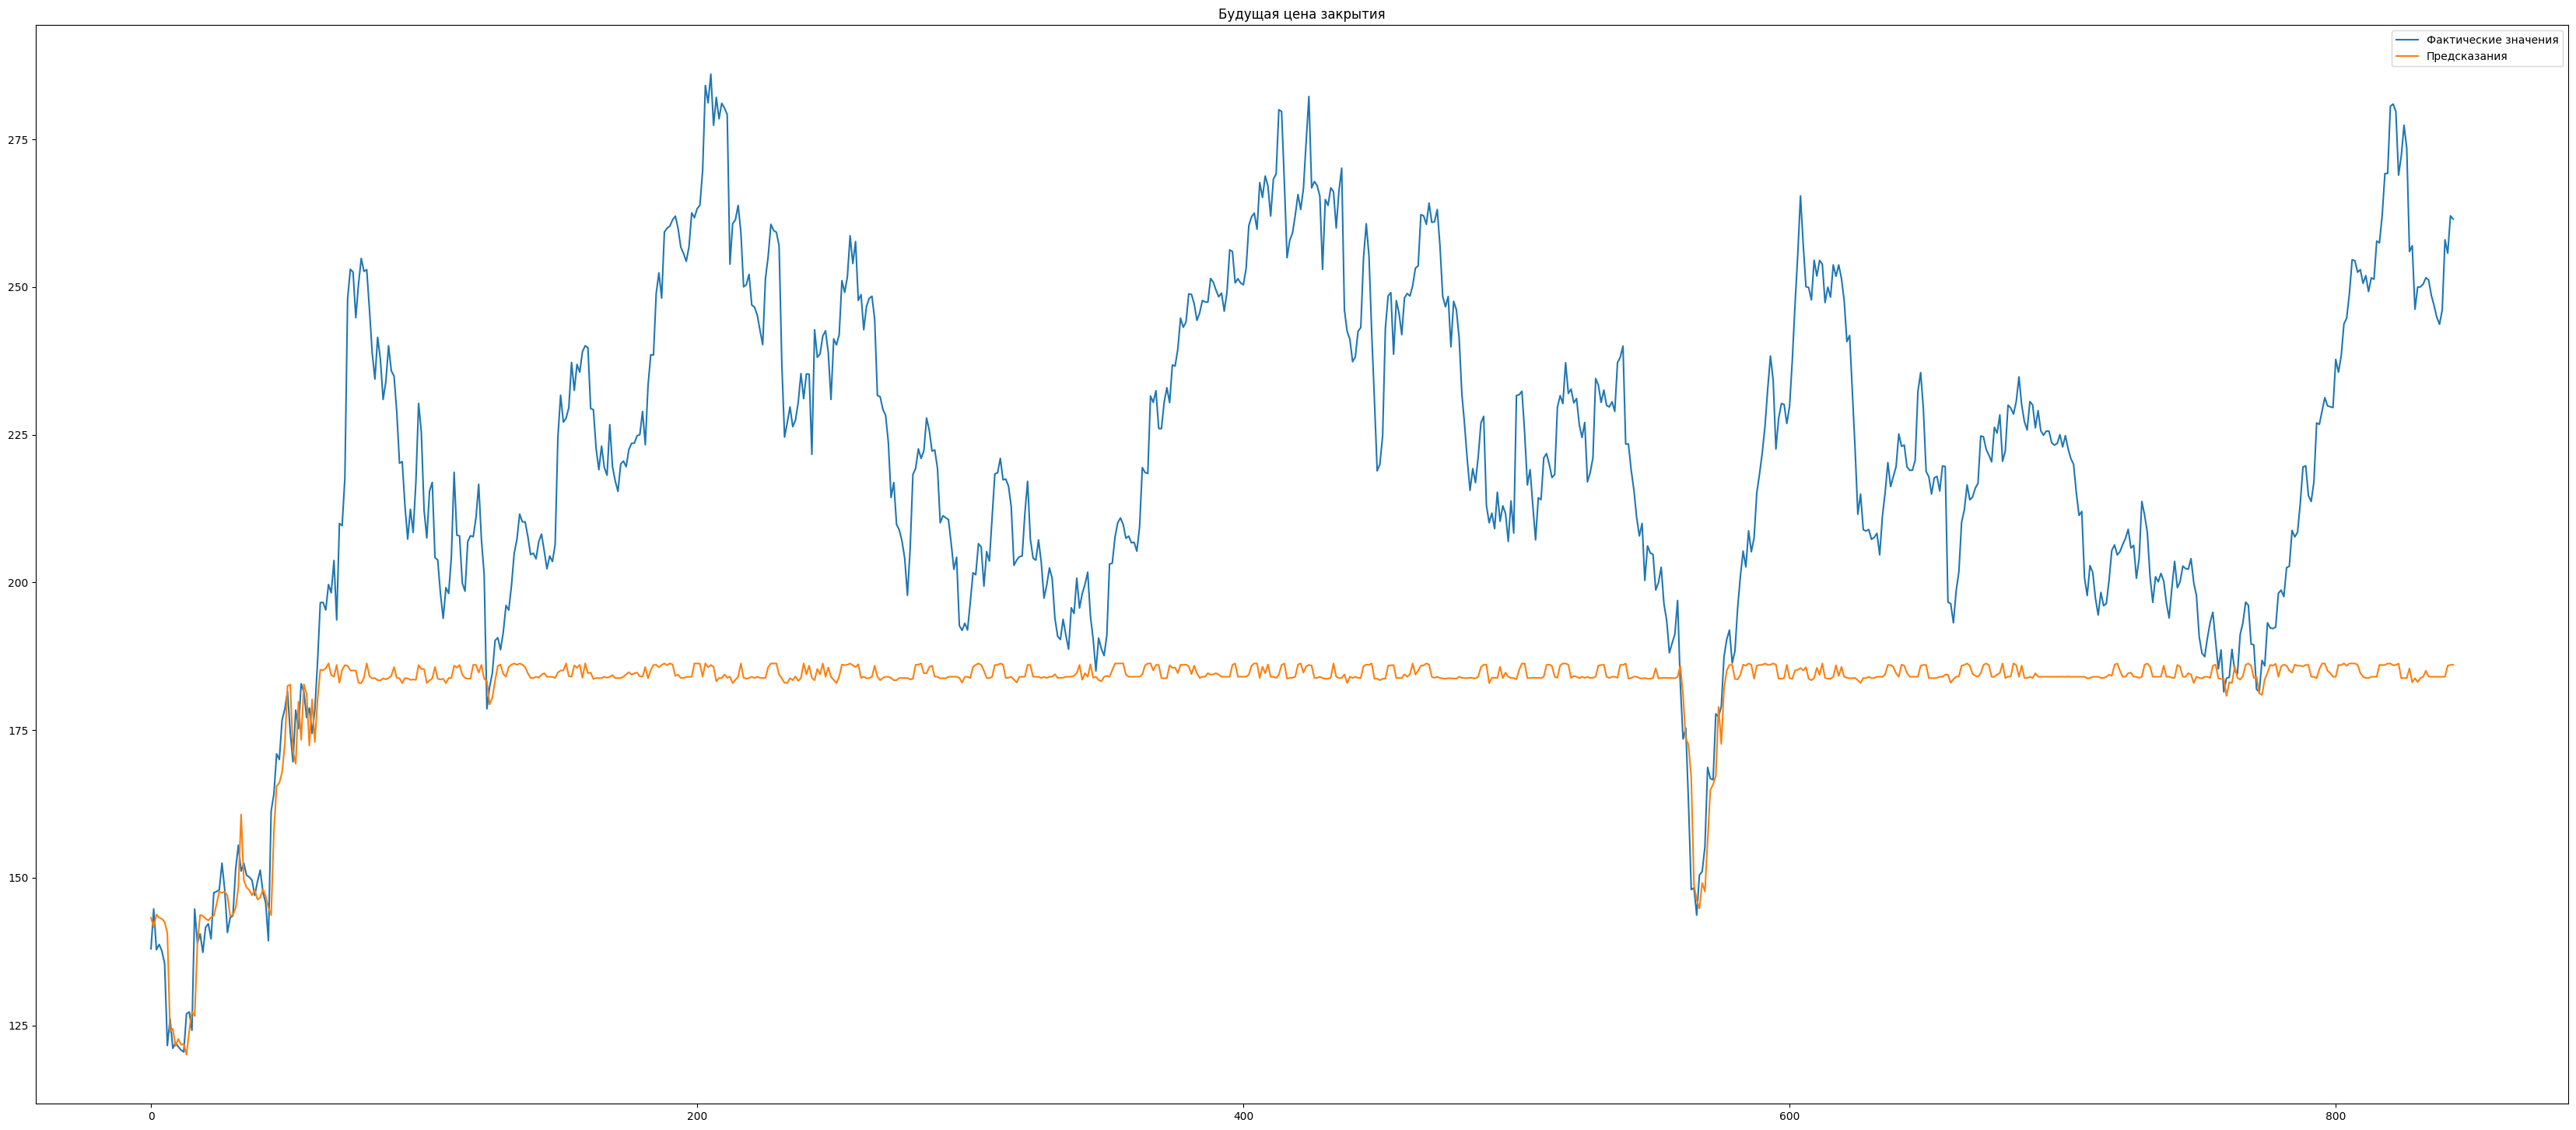

In [13]:
import matplotlib.pyplot as plt

scale = 1


def show_predict_on_test(y_test, y_pred, scale=1):
    y_test_new = sample_every_n(y_test, scale)
    y_pred_new = sample_every_n(y_pred, scale)

    plt.figure(figsize=(42, 18))
    plt.plot(y_test_new, label='Фактические значения')
    plt.plot(y_pred_new, label='Предсказания')
    plt.legend()
    plt.title('Будущая цена закрытия')
    plt.show()


show_predict_on_test(y_test.values, predicted_prices_forest, scale=scale)

In [14]:
# Более явный код
today_prices = sample_every_n(X_test['Close'].values, scale)

y_test = sample_every_n(y_test.values, scale)
y_pred = sample_every_n(predicted_prices_forest, scale)


tomorrow_actual_prices = y_test
tomorrow_predicted_prices = y_pred

# Фактическое направление (завтра vs сегодня)
actual_directions = (tomorrow_actual_prices > today_prices).astype(int)

# Предсказанное направление (предсказание завтра vs сегодня)
predicted_directions = (tomorrow_predicted_prices > today_prices).astype(int)

# Оценка качества классификации
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(actual_directions, predicted_directions)
print(f"Accuracy направления: {accuracy:.3f}")
print(confusion_matrix(actual_directions, predicted_directions))

Accuracy направления: 0.502
[[401  16]
 [404  23]]


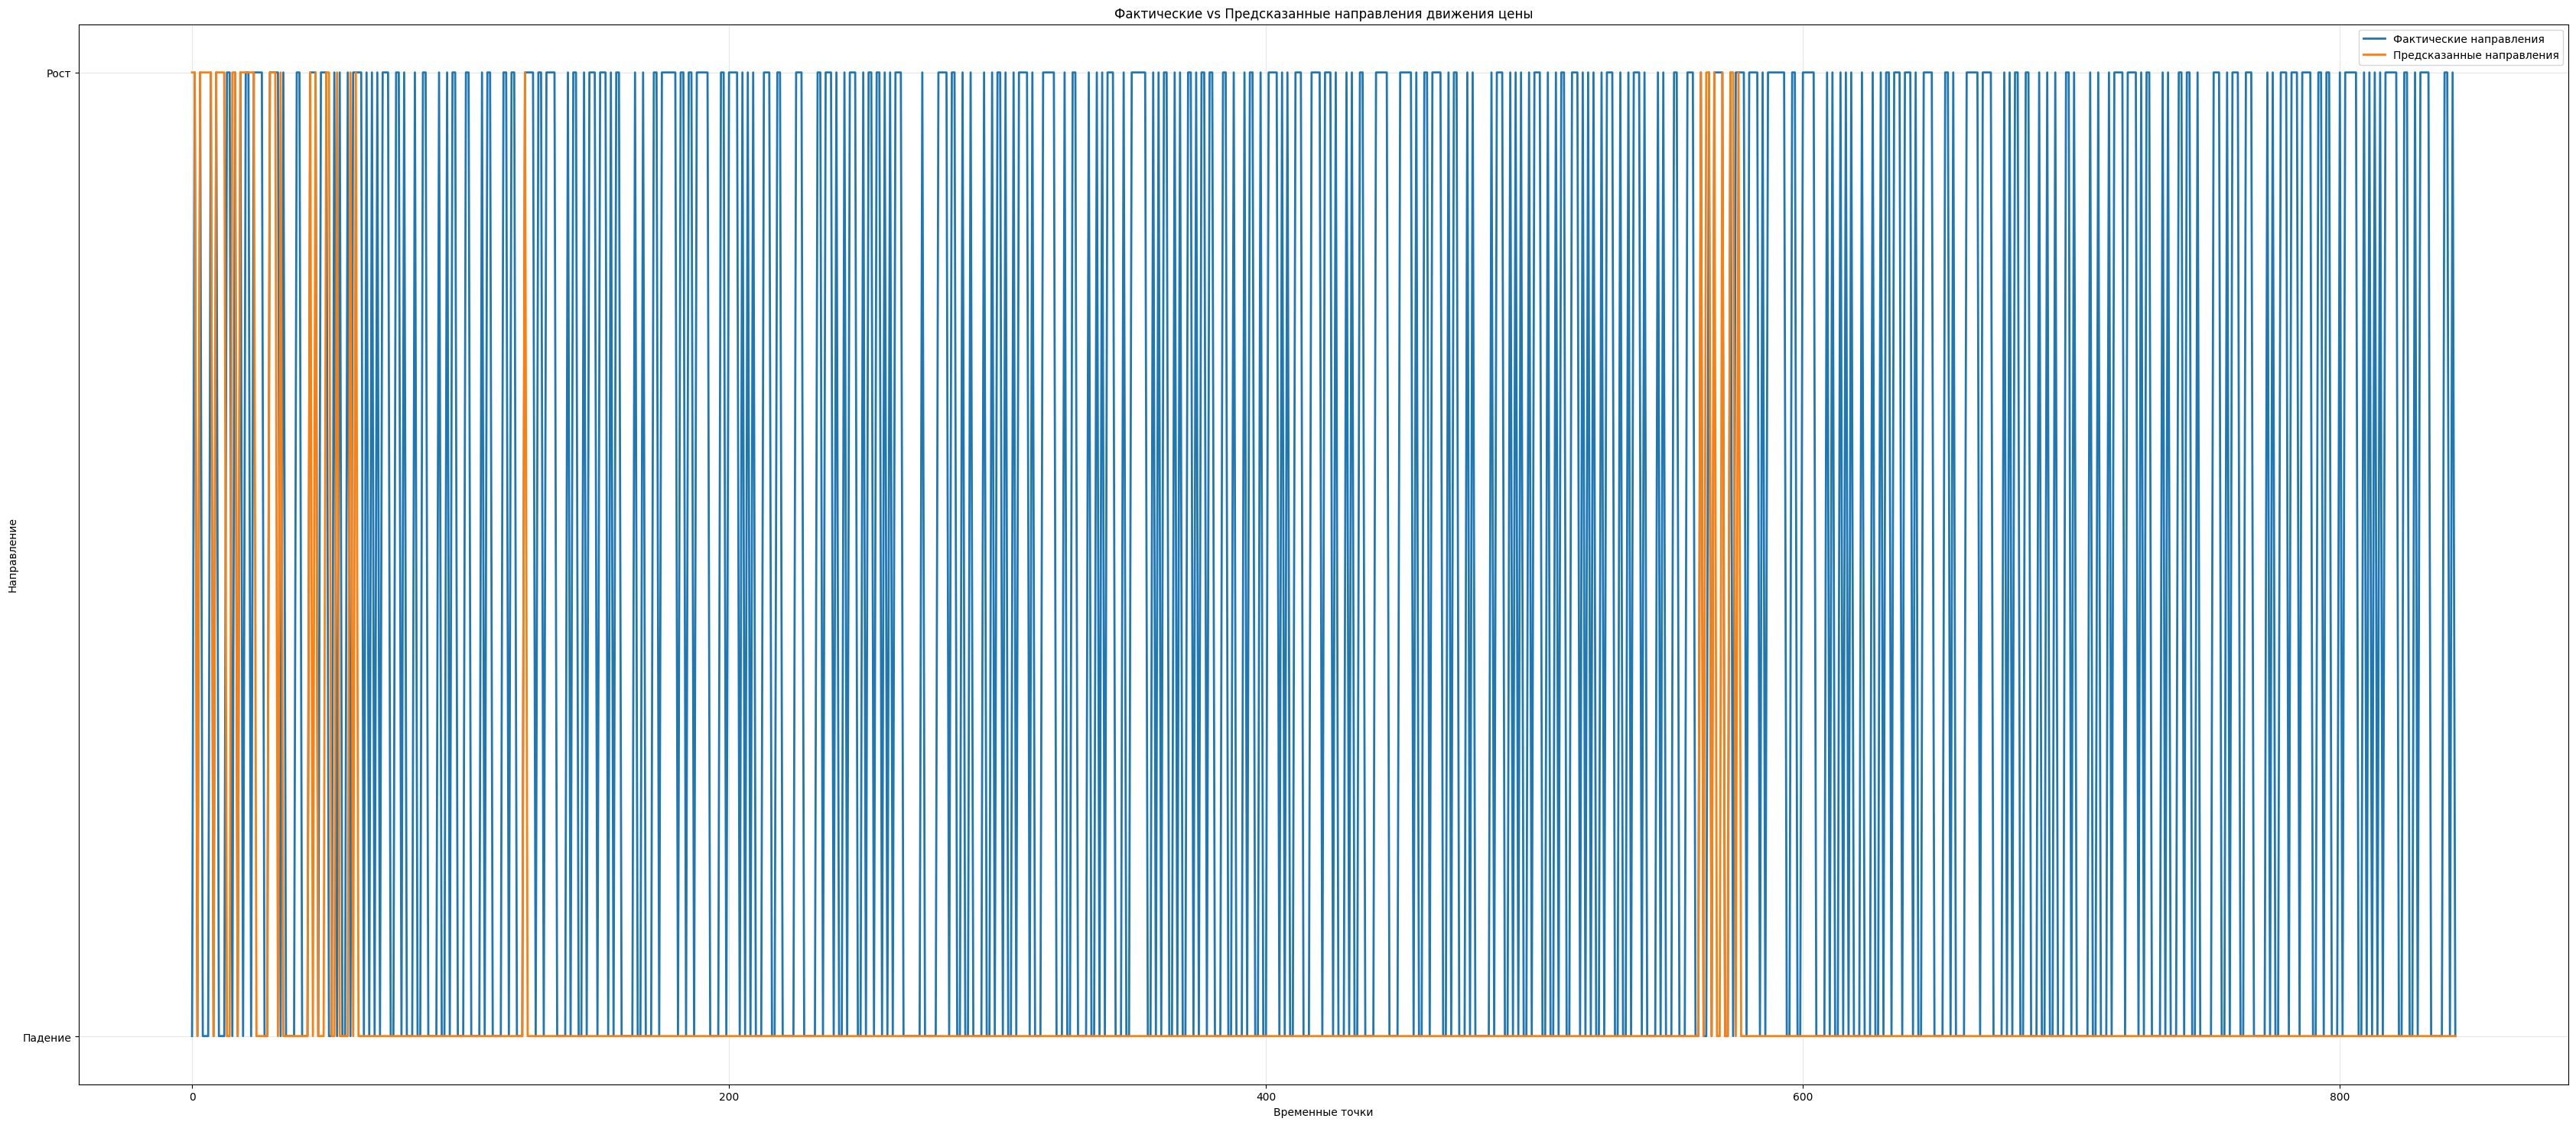

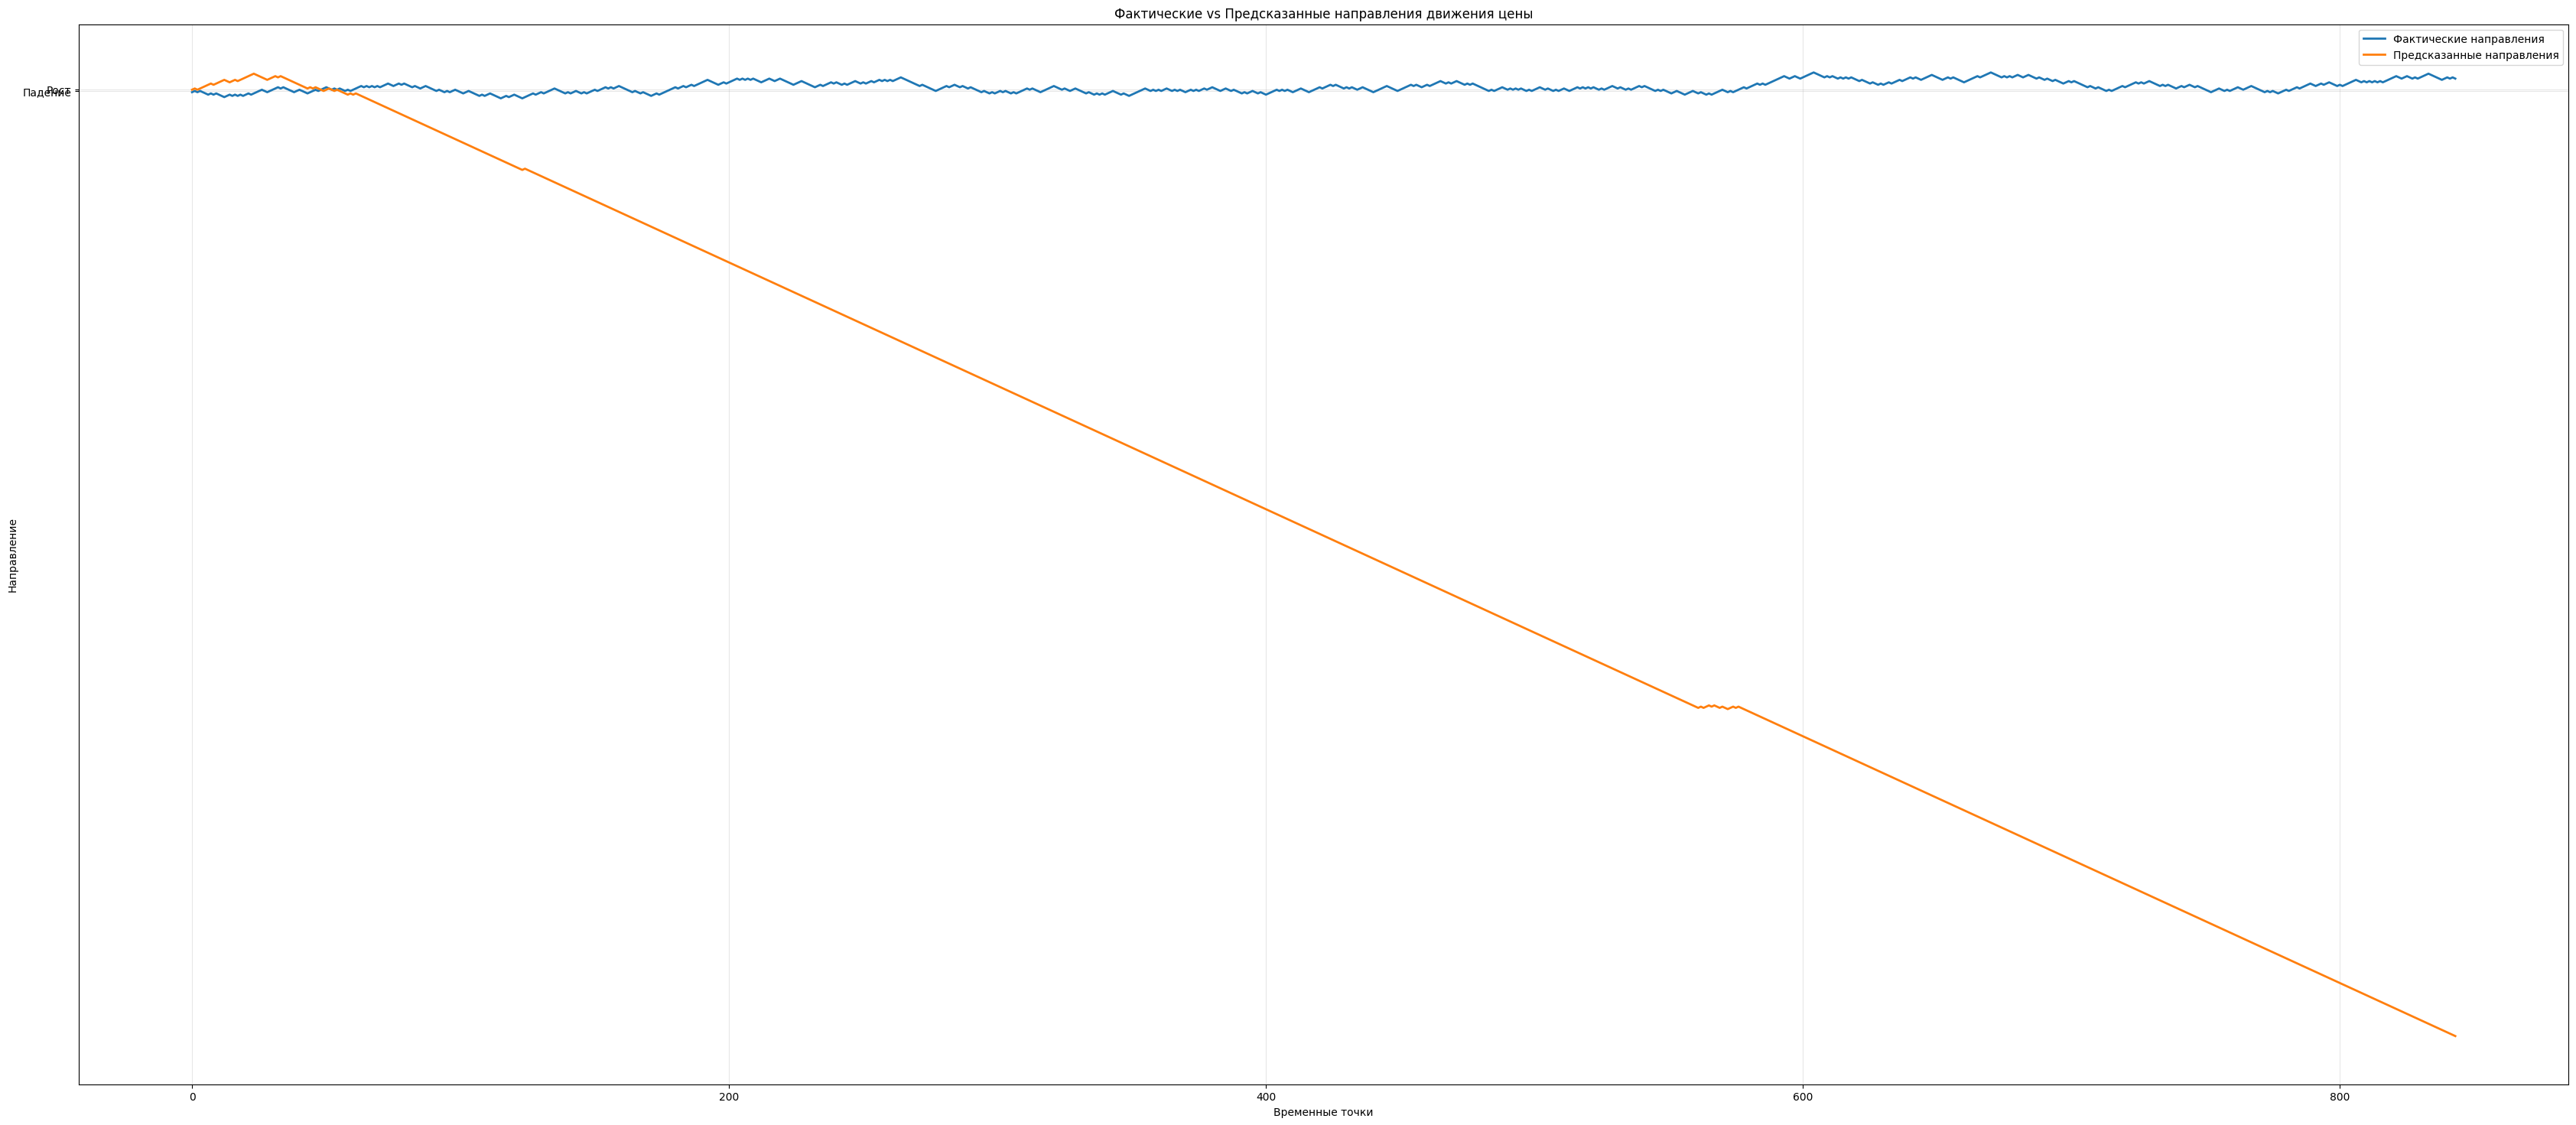

In [15]:
plt.figure(figsize=(42, 18))
plt.plot(actual_directions, label='Фактические направления', linewidth=2)
plt.plot(predicted_directions, label='Предсказанные направления', linewidth=2)
plt.yticks([0, 1], ['Падение', 'Рост'])
plt.xlabel('Временные точки')
plt.ylabel('Направление')
plt.title('Фактические vs Предсказанные направления движения цены')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


actual_graph = actual_directions.copy()
actual_graph[actual_graph == 0] = -1
for i in range(1, len(actual_graph)):
    actual_graph[i] += actual_graph[i-1]

predicted_graph = predicted_directions.copy()
predicted_graph[predicted_graph == 0] = -1
for i in range(1, len(predicted_graph)):
    predicted_graph[i] += predicted_graph[i-1]


plt.figure(figsize=(42, 18))
plt.plot(actual_graph, label='Фактические направления', linewidth=2)
plt.plot(predicted_graph, label='Предсказанные направления', linewidth=2)
plt.yticks([0, 1], ['Падение', 'Рост'])
plt.xlabel('Временные точки')
plt.ylabel('Направление')
plt.title('Фактические vs Предсказанные направления движения цены')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

100%|===================| 843/844 [00:51<00:00]        

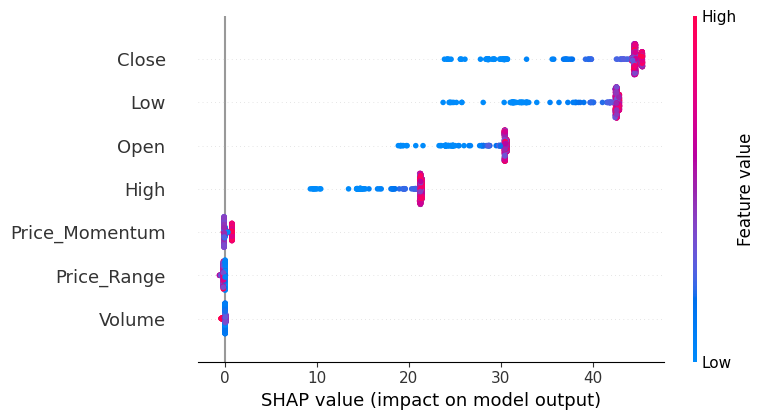

In [16]:
import shap


# Использование SHAP для случайного леса
explainer = shap.Explainer(model_forest, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

# Подбор гиперпараметров

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Пайплайн с масштабированием
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # масштабирование
    ('classifier', RandomForestRegressor(random_state=RANDOM_STATE))  # модель
])

# Просмотр пайплайна
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestRegressor(random_state=34))])

# Grid Search
- Перебирает все возможные комбинации указанных гиперпараметров.
- Для каждой комбинации обучает модель и проверяет качество на кросс-валидации.
- Возвращает лучшую комбинацию по заданной метрике (например, accuracy).

In [18]:
param_grid = {
    "classifier__n_estimators" : [100, 500],        
                             # Количество деревьев в лесе.
                             # Большее число деревьев обычно улучшает качество, но увеличивает время обучения.
                             # Варианты: 50, 100, 200, 500.

    "classifier__criterion" : ['squared_error', 'absolute_error'], 
                             # Критерий качества разбиений для каждого дерева.
                             # 'squared_error' — среднеквадратичная ошибка (по умолчанию),
                             # 'absolute_error' — средняя абсолютная ошибка,
                             # 'poisson' — для данных с распределением Пуассона.

    "classifier__max_depth" : [5, 20],            # Максимальная глубина каждого дерева.
                             # None — без ограничения (может переобучаться).
                             # Примеры: 5, 10, 20.

    "classifier__min_samples_split" : [2,5,10],    
                             # Минимальное количество образцов для разбиения узла.
                             # Увеличение уменьшает переобучение.

    "classifier__min_samples_leaf" : [1, 2, 4],
                             # Минимальное количество образцов в листе.
                     
                             # Увеличение делает модель более "плавной".

    "classifier__max_features" : [1.0, 'sqrt', 'log2'],        # Количество признаков, используемых при поиске лучшего разбиения.
                             # 1.0 — использовать все признаки (стандарт для регрессии),
                             # 'sqrt' — корень из числа признаков,
                             # 'log2' — логарифм по основанию 2, или число/доля признаков.

    "classifier__bootstrap" : [True, False],          # Использовать ли bootstrap-подвыборки при обучении деревьев.
                             # True — стандартный вариант, False — использовать все данные.

    # "classifier__n_jobs" : [None],             # Количество потоков.
                             # None — одно ядро, -1 — использовать все ядра процессора.

    # "classifier__min_impurity_decrease" : [0.0], # Минимальное уменьшение примеси для разбиения.
    
    # "classifier__ccp_alpha" : [0.0]
}

In [19]:
from sklearn.model_selection import GridSearchCV

# Создание сетки
gs_forest = GridSearchCV(
    estimator=pipeline,     # модель
    param_grid=param_grid,  # параметры
    scoring="r2",     # метрика
    cv=3,                   # K-folds для кросс валидации
    n_jobs=-1,              # параллель на всю катушку
    verbose=3,              # кол-во информации для отображения
    refit=True
)

# Обучение моделей
gs_forest.fit(X_train, y_train)

# Результаты
print("\nЛучшие параметры:")
for key, value in gs_forest.best_params_.items():
    print(f'{key} -> {value}')
print("\nЛучшее качество на кросс-валидации:", gs_forest.best_score_)
print("Точность на тесте:", gs_forest.score(X_test, y_test))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits

Лучшие параметры:
classifier__bootstrap -> True
classifier__criterion -> squared_error
classifier__max_depth -> 20
classifier__max_features -> 1.0
classifier__min_samples_leaf -> 2
classifier__min_samples_split -> 10
classifier__n_estimators -> 500

Лучшее качество на кросс-валидации: 0.3059035934816719
Точность на тесте: -0.9694303025423701


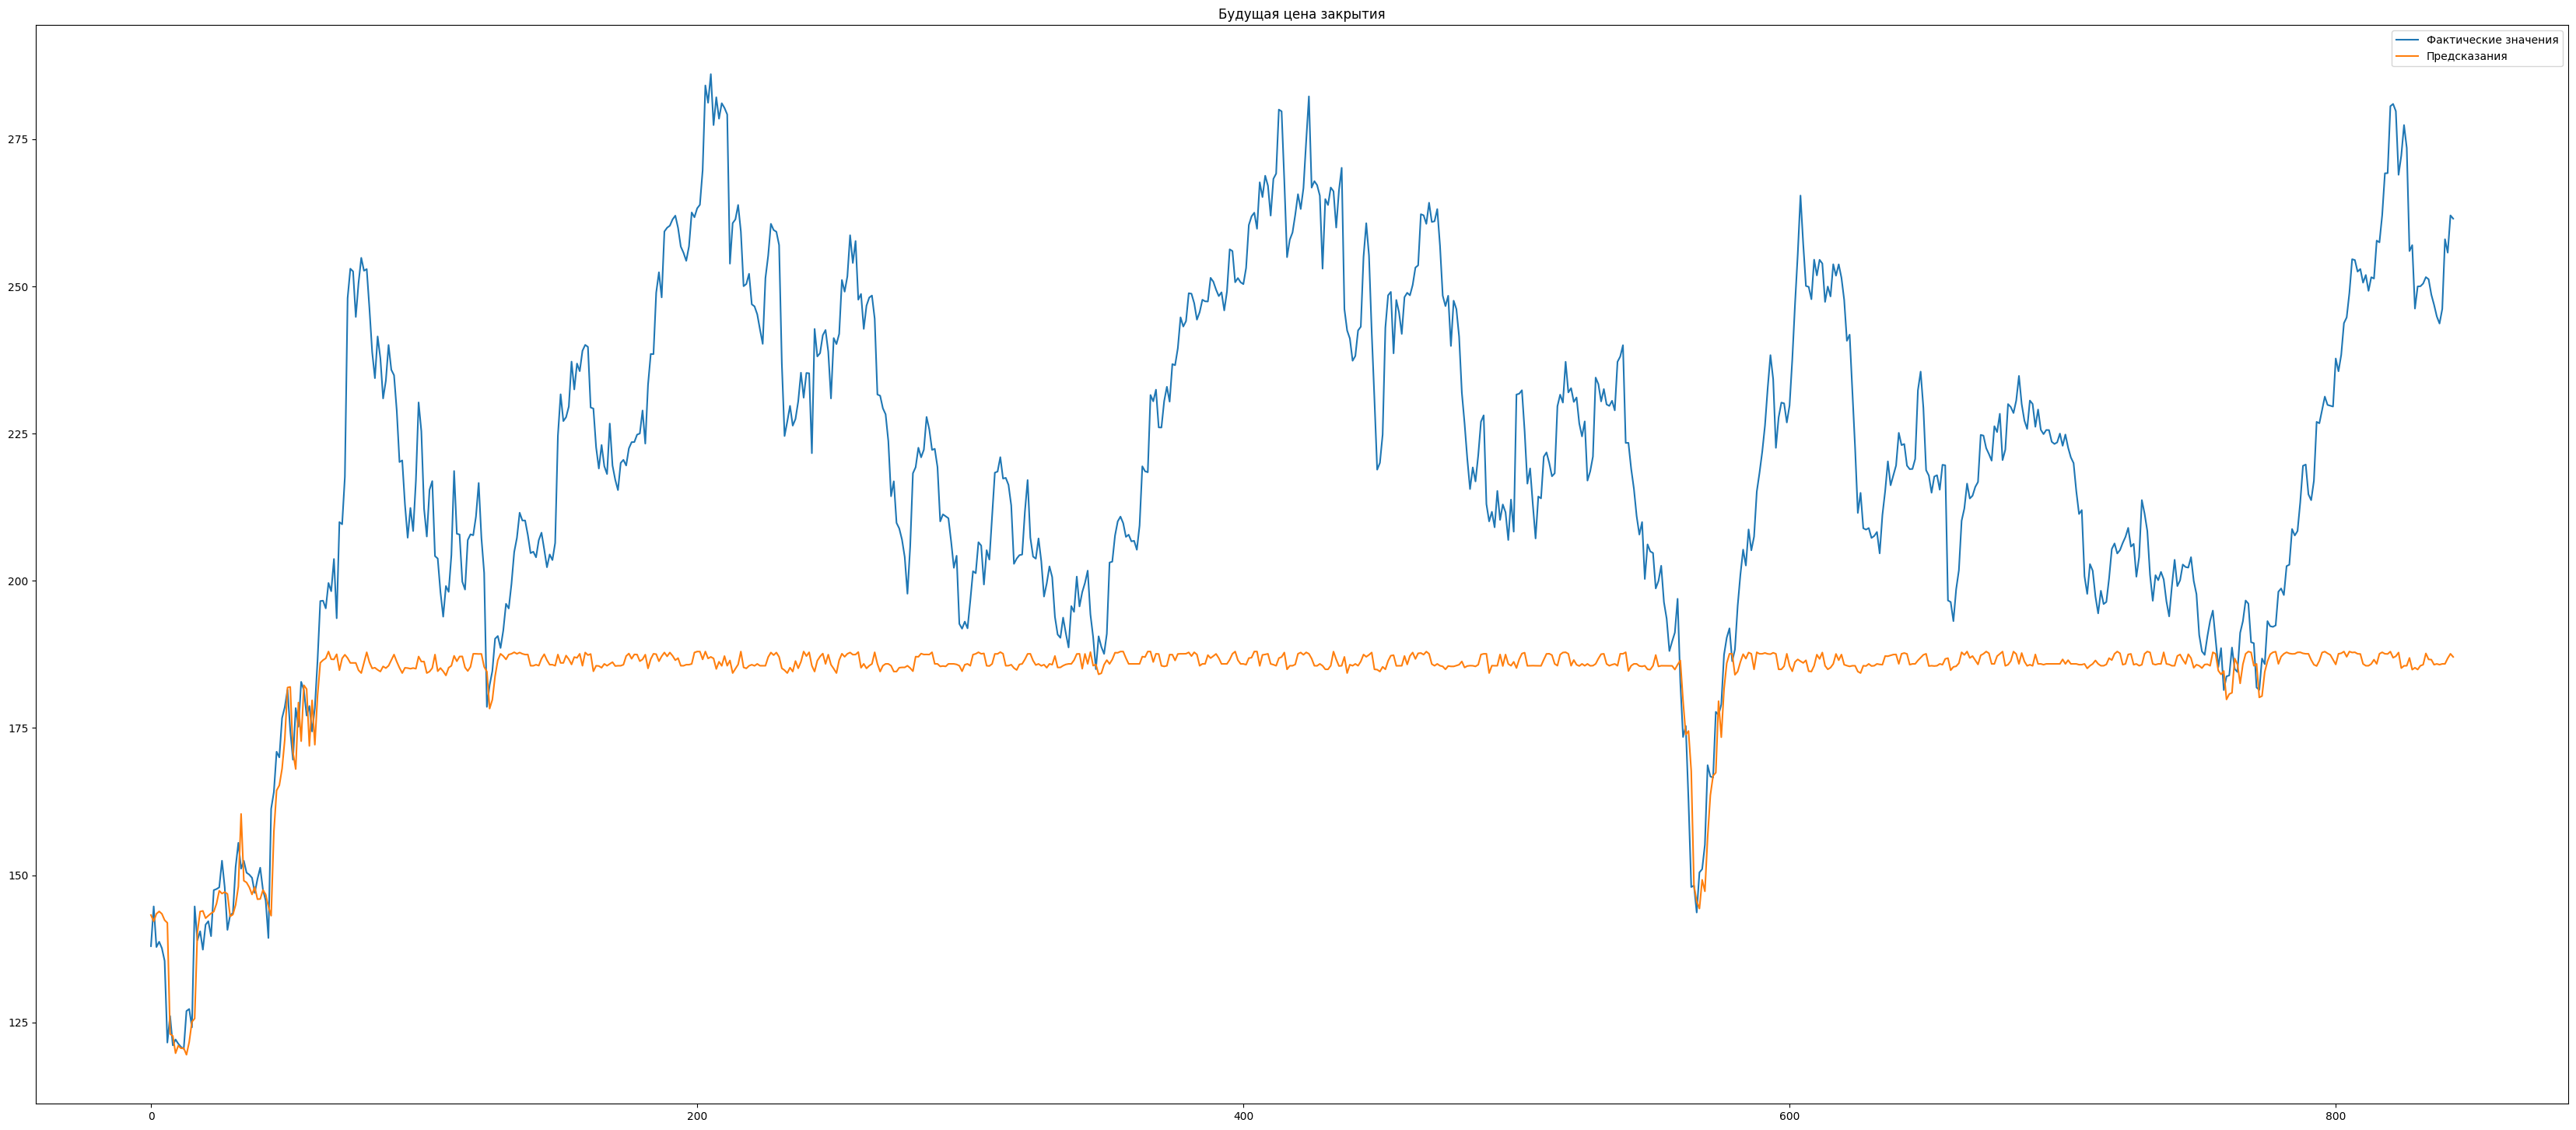

In [20]:
show_predict_on_test(y_test, gs_forest.predict(X_test), scale=scale)

# Random Search

* **Идея:** выбираем случайные комбинации гиперпараметров из заранее определённых диапазонов.
* **Плюсы:**
  * Прост в реализации.
  * Эффективнее, чем Grid Search для моделей с большим числом гиперпараметров.
  * Хорош для грубой оценки влияния гиперпараметров.
* **Минусы:**
  * Не гарантирует нахождение оптимального решения.
  * Требует большого числа итераций при сложных пространствах гиперпараметров.


In [21]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipeline,                 # модель
    param_distributions=param_grid,     # параметры
    n_iter=40,                          # кол-во попыток (кандидатов)
    scoring='r2',                 # метрика
    cv=5,                               # K-folds для кросс валидации
    n_jobs=-1,                          # параллель на всю катушку
    verbose=3                           # кол-во информации для отображения
)

random_search.fit(X_train, y_train)

# Результаты
print("\nЛучшие параметры:")
for key, value in random_search.best_params_.items():
    print(f'{key} -> {value}')
print("\nЛучшее качество на кросс-валидации:", random_search.best_score_)
print("Точность на тесте:", random_search.score(X_test, y_test))

Fitting 5 folds for each of 40 candidates, totalling 200 fits

Лучшие параметры:
classifier__n_estimators -> 500
classifier__min_samples_split -> 10
classifier__min_samples_leaf -> 2
classifier__max_features -> 1.0
classifier__max_depth -> 20
classifier__criterion -> absolute_error
classifier__bootstrap -> True

Лучшее качество на кросс-валидации: 0.15808298344454838
Точность на тесте: -1.0335442569785727


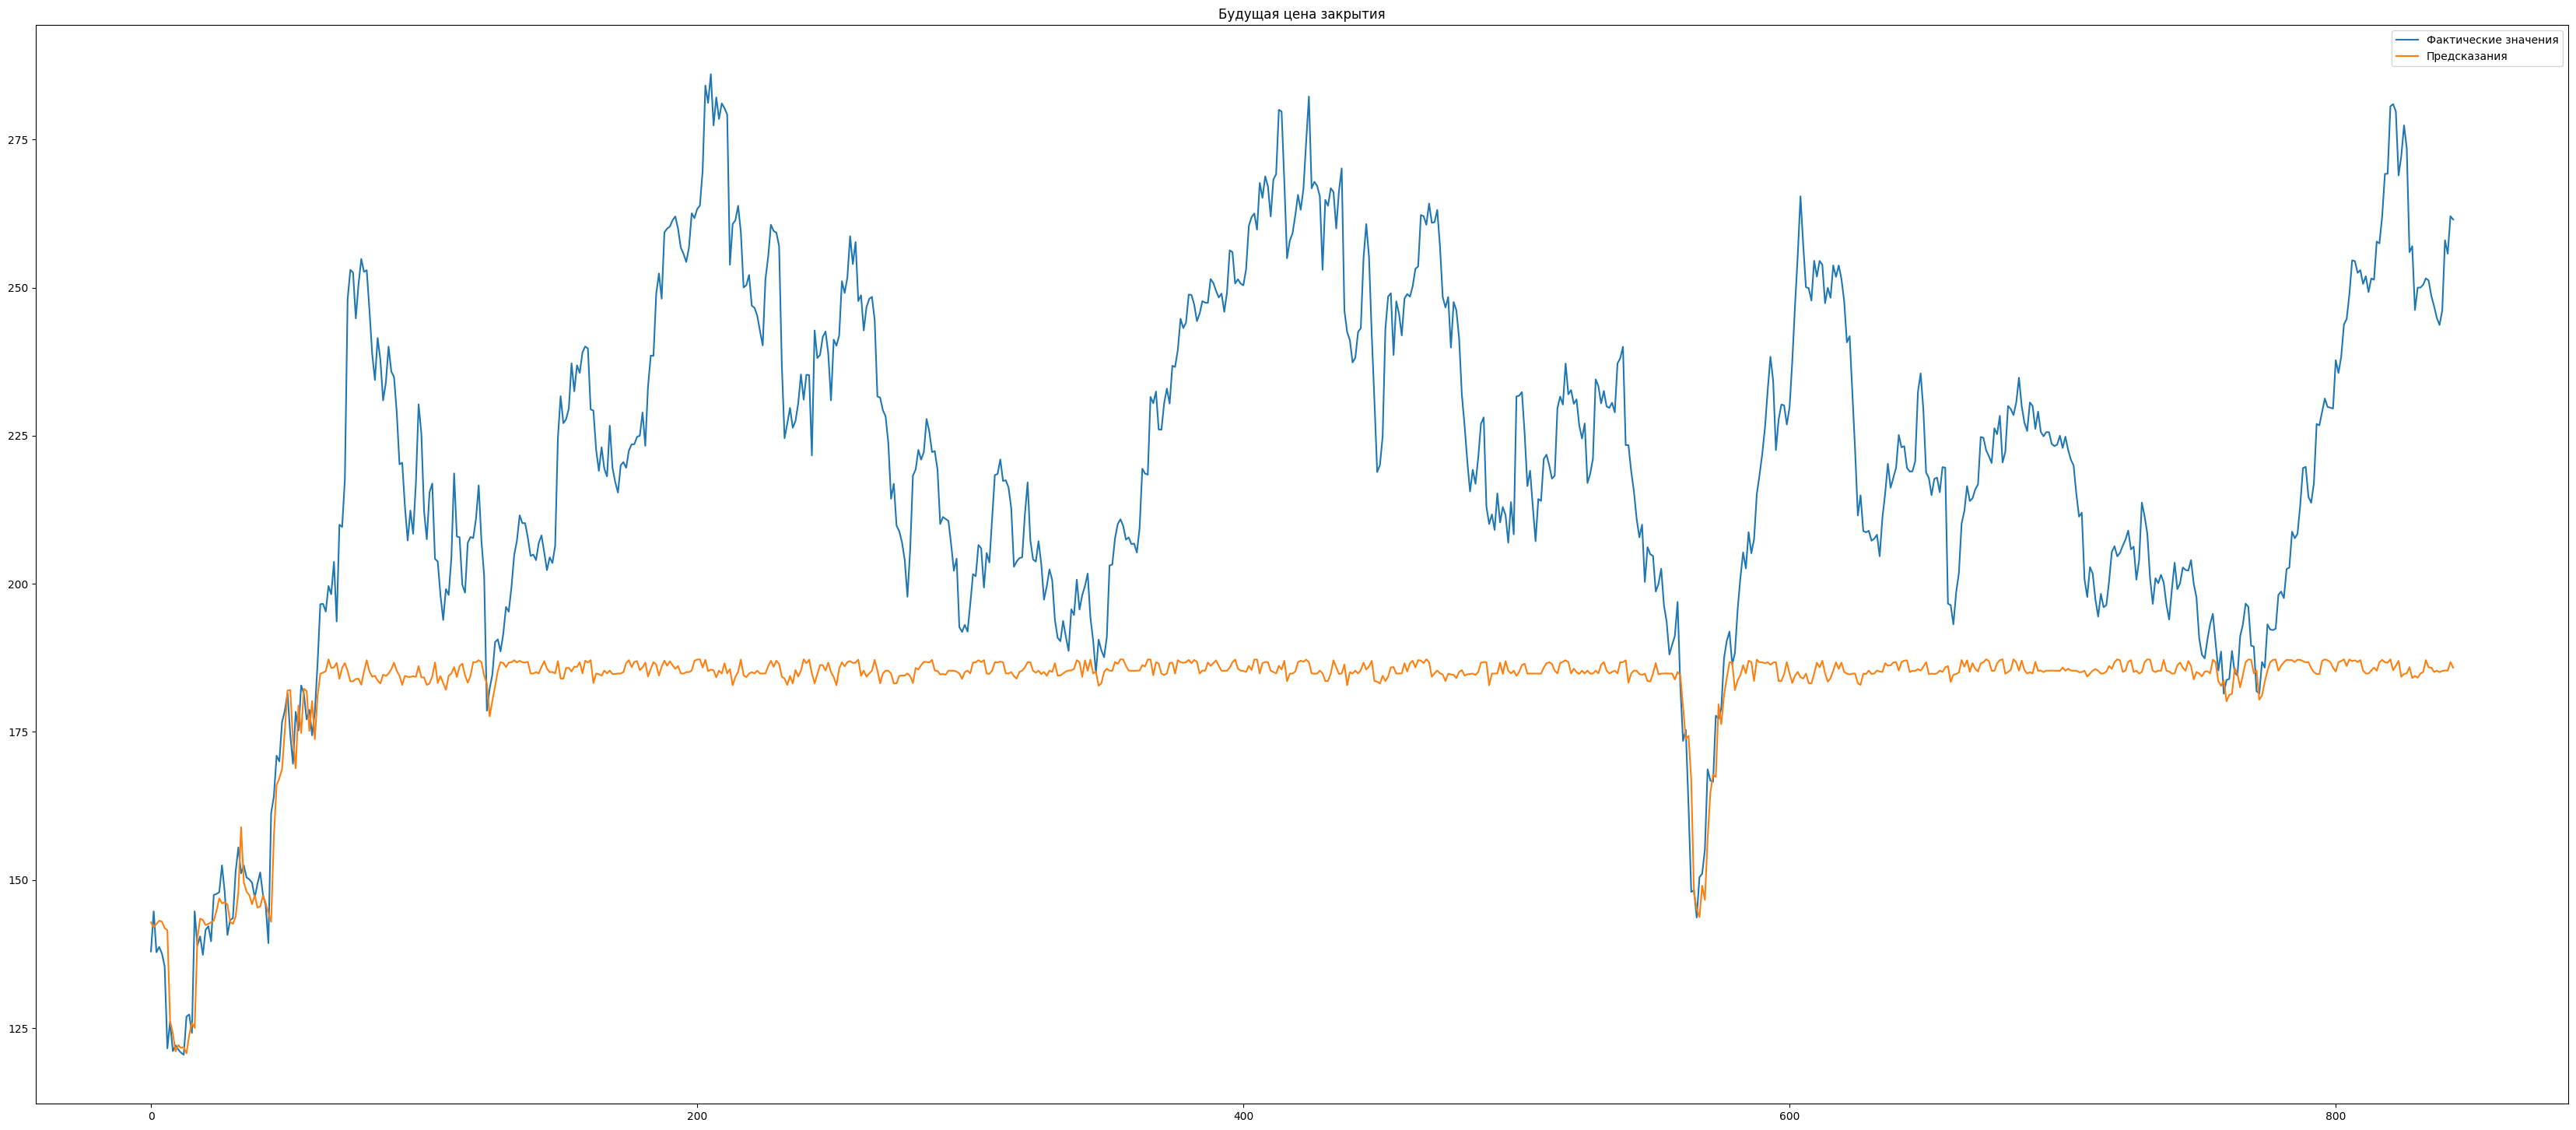

In [22]:
show_predict_on_test(y_test, random_search.predict(X_test), scale=scale)

# Байесовская оптимизация с Optuna

* **Идея:** строим вероятностную модель функции потерь и используем её, чтобы выбирать новые гиперпараметры «умнее», чем случайно.
* **Плюсы:**
  * Эффективнее Random Search при сложных пространствах гиперпараметров.
  * Балансирует *exploration* (исследование) и *exploitation* (использование лучших областей).
* **Минусы:**
  * Сложнее для понимания и настройки.
  * Требует больше зависимостей (Optuna, иногда PyTorch/Scikit-learn).

[Подробнее](https://optuna.org/)

In [23]:
import optuna
from sklearn.model_selection import cross_val_score

def objective_dt(trial):
    # Настройка гиперпараметров для Random Forest
    n_estimators = trial.suggest_int('classifier__n_estimators', 100, 500)
    criterion = trial.suggest_categorical('classifier__criterion', ['squared_error', 'absolute_error'])
    max_depth = trial.suggest_int('classifier__max_depth', 1, 20)
    min_samples_split = trial.suggest_int('classifier__min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('classifier__min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('classifier__max_features', [1.0, 'sqrt', 'log2'])
    bootstrap = trial.suggest_categorical('classifier__bootstrap', [True, False])


    pipeline.set_params(
        classifier__n_estimators=n_estimators,
        classifier__criterion=criterion,
        classifier__max_depth=max_depth,
        classifier__min_samples_split=min_samples_split,
        classifier__min_samples_leaf=min_samples_leaf,
        classifier__max_features=max_features,
        classifier__bootstrap=bootstrap
    )


    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2').mean()
    return score


# Создаём исследование
study_dt = optuna.create_study(
    direction='maximize'  # максимизирукм cross_val_score чтобы он был наибольшим
)

study_dt.optimize(
    objective_dt,
    n_trials=60,  # количество попыток
    n_jobs=-1,
)


# Лучшие параметры
print("\nЛучшие параметры Random Forest:")
for key, value in study_dt.best_params.items():
    print(f'{key} -> {value}')

pipeline.set_params(**study_dt.best_params)
pipeline.fit(X_train, y_train)
print("\nЛучшее качество на кросс-валидации:", cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2').mean())
print("Точность Random Forest на тесте:", pipeline.score(X_test, y_test))


[I 2025-11-22 19:21:32,036] A new study created in memory with name: no-name-11bd95e0-07f2-4166-a0a5-a5256b96dba1
[I 2025-11-22 19:22:00,339] Trial 14 finished with value: 0.12704787126449874 and parameters: {'classifier__n_estimators': 111, 'classifier__criterion': 'squared_error', 'classifier__max_depth': 19, 'classifier__min_samples_split': 13, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__bootstrap': False}. Best is trial 14 with value: 0.12704787126449874.
[I 2025-11-22 19:22:01,208] Trial 12 finished with value: 0.11638097120109947 and parameters: {'classifier__n_estimators': 123, 'classifier__criterion': 'squared_error', 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__bootstrap': True}. Best is trial 14 with value: 0.12704787126449874.
[I 2025-11-22 19:22:01,398] Trial 9 finished with value: -0.7102425269603565 and parameters: {'classifier__n


Лучшие параметры Random Forest:
classifier__n_estimators -> 414
classifier__criterion -> squared_error
classifier__max_depth -> 16
classifier__min_samples_split -> 4
classifier__min_samples_leaf -> 4
classifier__max_features -> 1.0
classifier__bootstrap -> False

Лучшее качество на кросс-валидации: 0.12119828411633433
Точность Random Forest на тесте: -0.7661286145009112


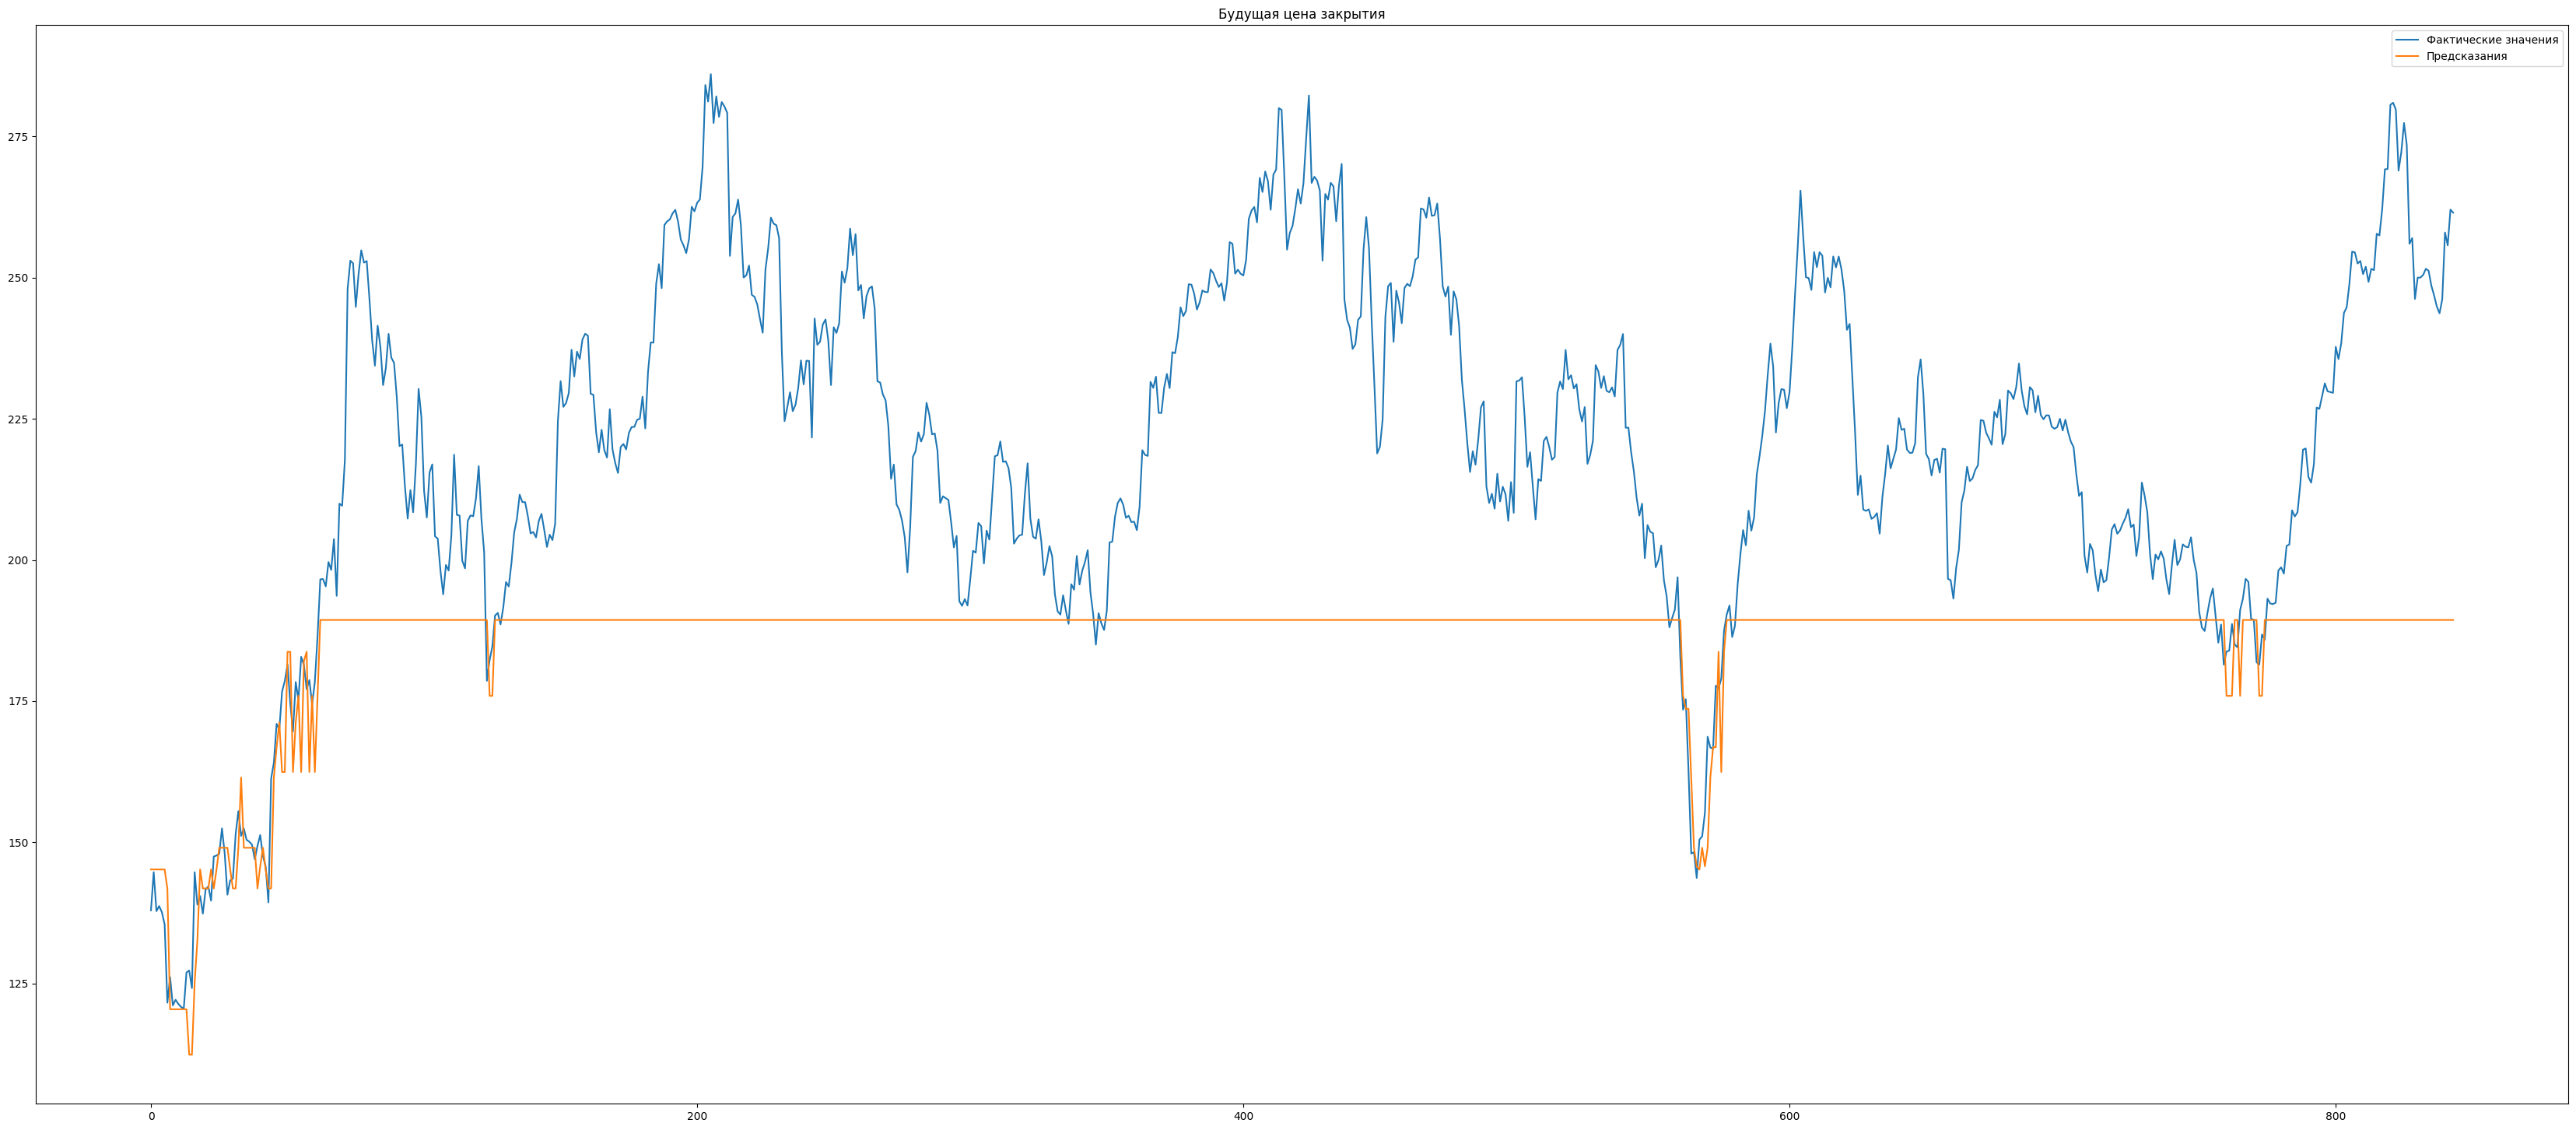

In [24]:
show_predict_on_test(y_test, pipeline.predict(X_test), scale=scale)

### Сравнение Optuna, Random search и Grid Search


In [25]:
print(f"                                   | {'Grid Search':20} | {'Random Search':20} | {'Optuna':20} |")
print(f"Лучшее качество на кросс-валидации | {gs_forest.best_score_:20} | {random_search.best_score_:20} | {cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2').mean():20} |")
print(f"Точность на тесте                  | {gs_forest.score(X_test, y_test):20} | {random_search.score(X_test, y_test):20} | {pipeline.score(X_test, y_test):20} |")


                                   | Grid Search          | Random Search        | Optuna               |
Лучшее качество на кросс-валидации |   0.3059035934816719 |  0.15808298344454838 |  0.12119828411633433 |
Точность на тесте                  |  -0.9694303025423701 |  -1.0335442569785727 |  -0.7661286145009112 |


# TPOT - Automated Machine Learning (AutoML) инструмент

TPOT (Tree-based Pipeline Optimization Tool) - это библиотека автоматизированного машинного обучения (AutoML), которая использует генетические алгоритмы для оптимизации полных конвейеров машинного обучения. В отличие от Optuna и RandomizedSearchCV, которые оптимизируют только гиперпараметры существующей модели, TPOT автоматически:


* Выбирает лучшие алгоритмы машинного обучения
* Создает оптимальные preprocessing steps
* Настраивает гиперпараметры
* Строит полные конвейеры обработки данных

## Ключевые особенности TPOT

### 1. **Генетическое программирование**
TPOT использует эволюционные алгоритмы для "размножения" и "мутации" конвейеров, постепенно улучшая их качество.

### 2. **Автоматический подбор моделей**
Может выбирать между различными классификаторами/регрессорами:
- Decision Trees, Random Forest, Gradient Boosting
- SVM, KNN, Logistic Regression
- Neural Networks и другие

### 3. **Предобработка данных**
Автоматически добавляет необходимые этапы:
- StandardScaler, MinMaxScaler, RobustScaler
- PCA, SelectPercentile, VarianceThreshold
- OneHotEncoding, PolynomialFeatures

## Преимущества TPOT

- **Экономия времени** - автоматизирует рутинные задачи
- **Обнаружение неочевидных решений** - может найти нестандартные комбинации методов
- **Воспроизводимость** - генерирует готовый Python код
- **Избегает переобучения** - использует кросс-валидацию

[Подробнее](https://github.com/EpistasisLab/tpot?ysclid=mhrqdj7la9508680297)

In [26]:
!pip install tpot


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\JustDema\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [27]:
from tpot import TPOTRegressor
from sklearn.metrics import r2_score, mean_squared_error 


# Создаём TPOT-классификатор
tpot = TPOTRegressor(
    generations=5,        # количество поколений эволюций
    population_size=20,   # размер популяции
    verbose=4,            # уровень детализации вывода
    random_state=RANDOM_STATE,
    cv=5,                 # количество фолдов кросс-валидации
)



In [28]:
# Обучаем
print("Начало оптимизации с TPOT...")
tpot.fit(X_train, y_train)


Начало оптимизации с TPOT...


C:\Users\JustDema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tpot\tpot_estimator\estimator.py:458: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
Generation:  20%|██        | 1/5 [01:50<07:20, 110.07s/it]

Generation:  1
Best mean_squared_error score: -7.195283524333777


Generation:  40%|████      | 2/5 [04:20<06:41, 133.72s/it]

Generation:  2
Best mean_squared_error score: -6.675418621372634


Generation:  60%|██████    | 3/5 [05:21<03:21, 100.63s/it]

Generation:  3
Best mean_squared_error score: -6.675418621372634


Generation:  80%|████████  | 4/5 [06:52<01:36, 96.72s/it] 

Generation:  4
Best mean_squared_error score: -6.675418621372634


Generation: 100%|██████████| 5/5 [07:51<00:00, 94.30s/it]
2025-11-22 19:33:05,758 - distributed.scheduler - ERROR - Removing worker 'tcp://127.0.0.1:52392' caused the cluster to lose scattered data, which can't be recovered: {'DataFrame-dad41117d4fd773cdd504948f0063891', 'Series-cb0eafdf726ae495836ea2e2b8948c91'} (stimulus_id='handle-worker-cleanup-1763829185.7586684')


Generation:  5
Best mean_squared_error score: -6.675418621372634


TPOTRegressor(cv=5, random_state=34,
              search_space=<tpot.search_spaces.pipelines.sequential.SequentialPipeline object at 0x000002DD8CF6E310>,
              verbose=4)

In [29]:
# Оценка качества
y_pred = tpot.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2 на тестовой выборке: {test_r2:.4f}")
print(f"RMSE на тестовой выборке: {test_rmse:.4f}")

# Лучшие параметры и конвейер
print("\nЛучший конвейер:")
print(tpot.fitted_pipeline_)

R2 на тестовой выборке: 0.9668
RMSE на тестовой выборке: 5.7238

Лучший конвейер:
Pipeline(steps=[('robustscaler',
                 RobustScaler(quantile_range=(0.0389269543521,
                                              0.8136600176868))),
                ('variancethreshold',
                 VarianceThreshold(threshold=0.001012577158)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('linearsvr',
                 

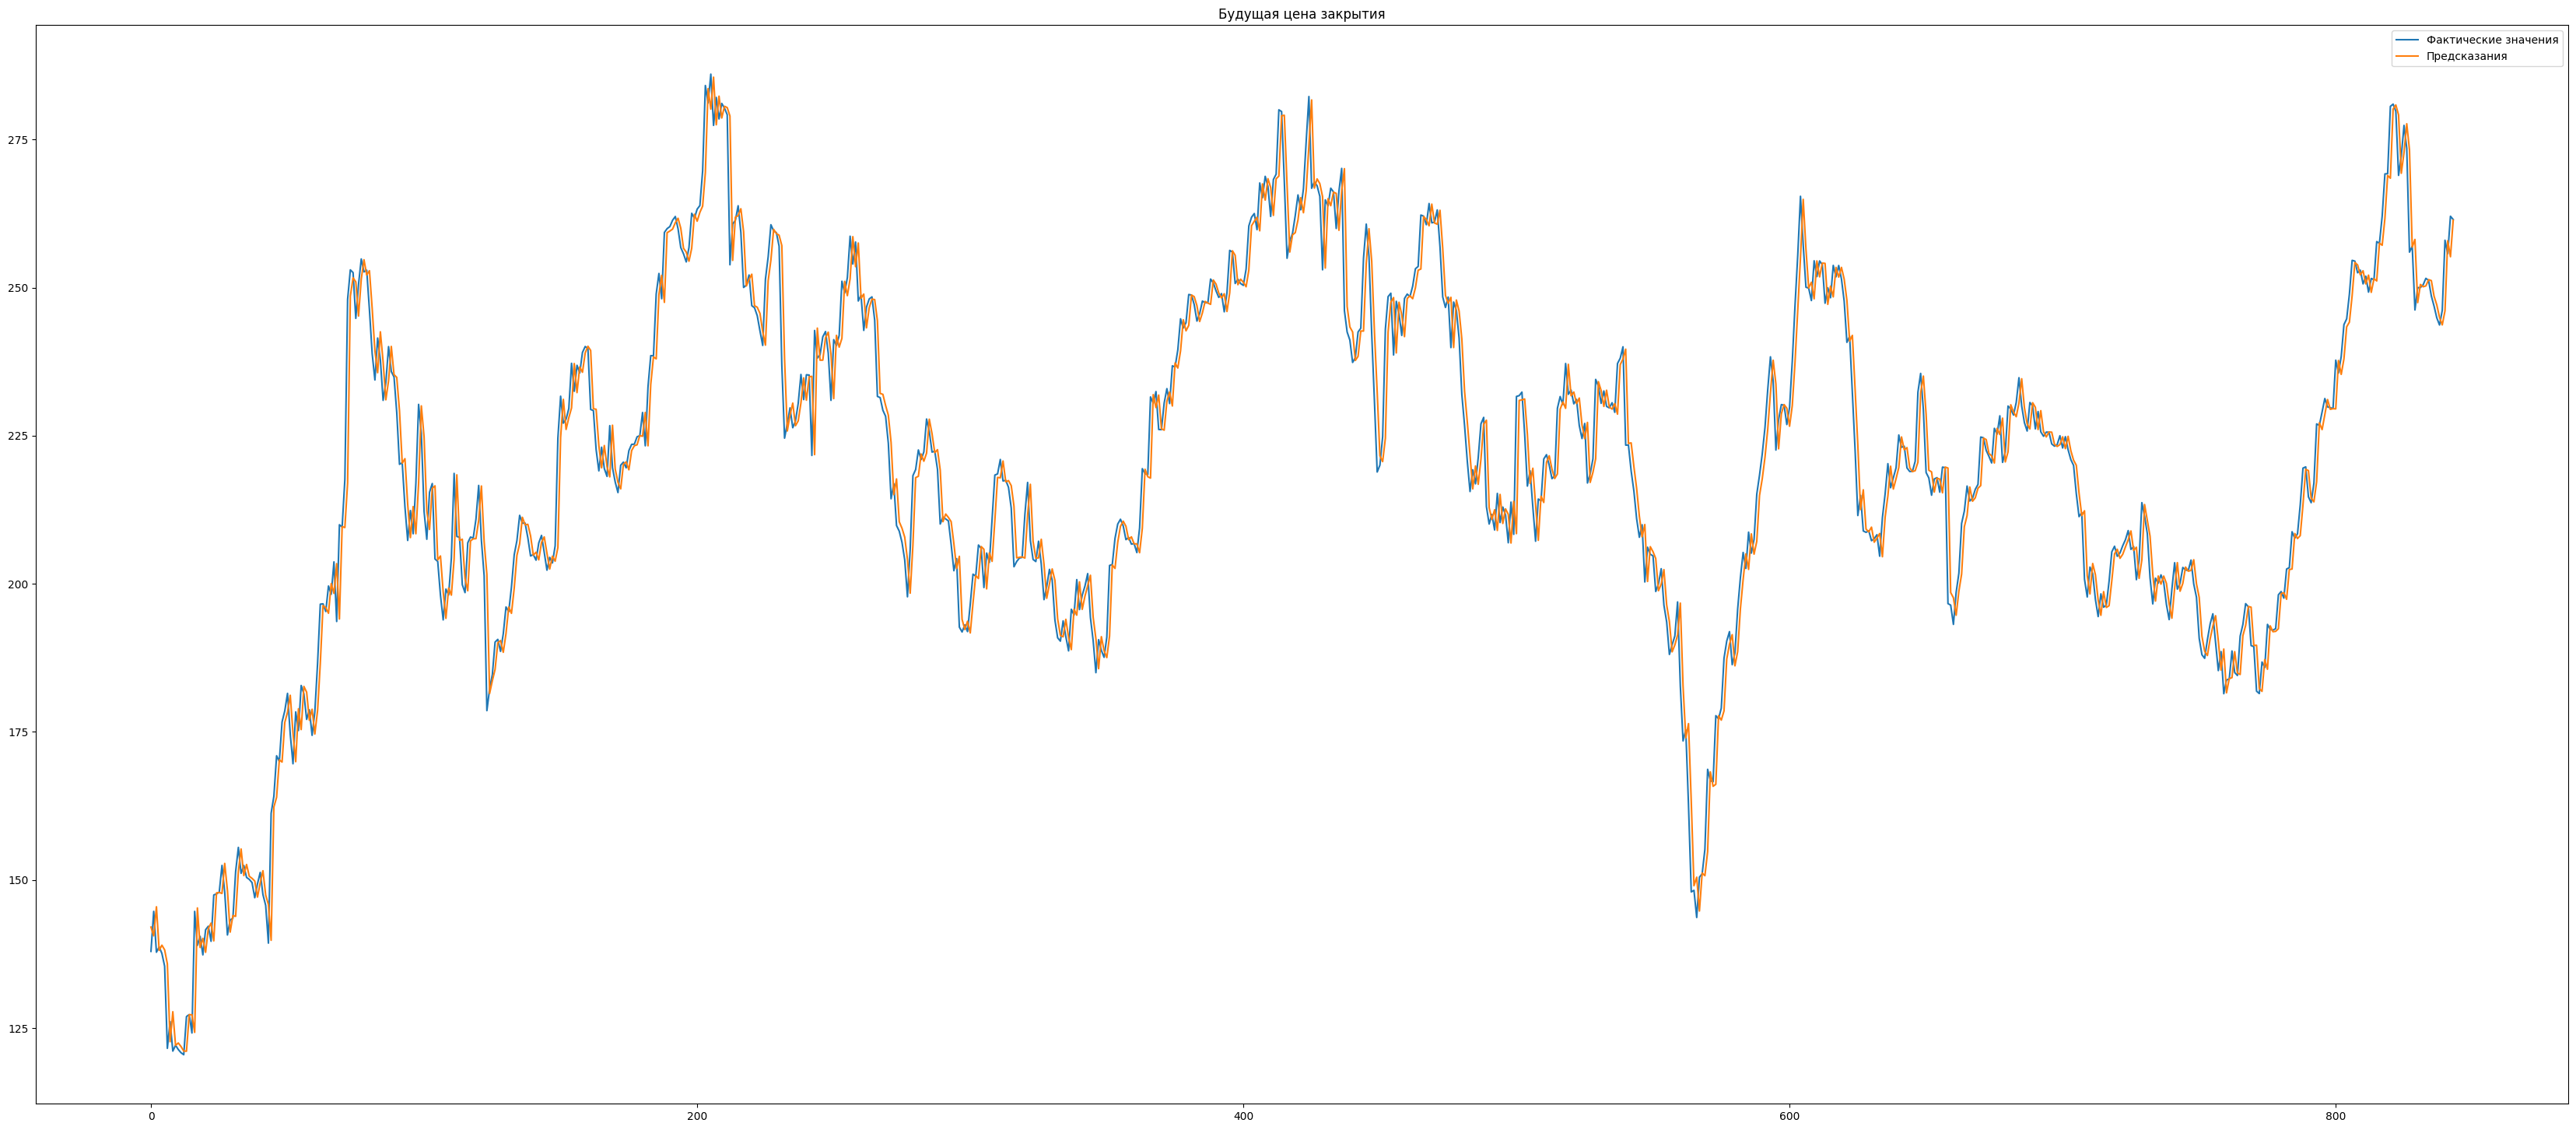

In [30]:
show_predict_on_test(y_test, y_pred, scale=scale)

# Сравнение

| Метод | Что оптимизирует | Автоматизация | Время | Качество |
|-------|------------------|---------------|-------|----------|
| **Optuna** | Гиперпараметры модели | Средняя | Среднее | Высокое |
| **RandomizedSearchCV** | Гиперпараметры модели | Низкая | Быстрое | Среднее |
| **TPOT** | Полный конвейер + модели | Полная | Длительное | Очень высокое |

In [31]:
# !pip install lime 
# !pip install shap

In [32]:
import lime
import lime.lime_tabular

# Использование LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, 
    feature_names=X.columns, 
    mode='regression',  # ← ИЗМЕНИТЬ НА 'regression'
    discretize_continuous=True
    )


i = 33  # пример для интерпретации
exp = explainer.explain_instance(X_test.iloc[i].values, tpot.predict, num_features=5)

exp.as_list()

C:\Users\JustDema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


[('Close > 35.21', 78.55754223943275),
 ('Low > 34.62', 56.85725299061726),
 ('High > 35.90', -52.01859042184926),
 ('Open > 35.26', -4.906899237468868),
 ('Price_Range > 2.04', 4.317698780120401)]

 96%|=================== | 814/844 [00:22<00:00]       

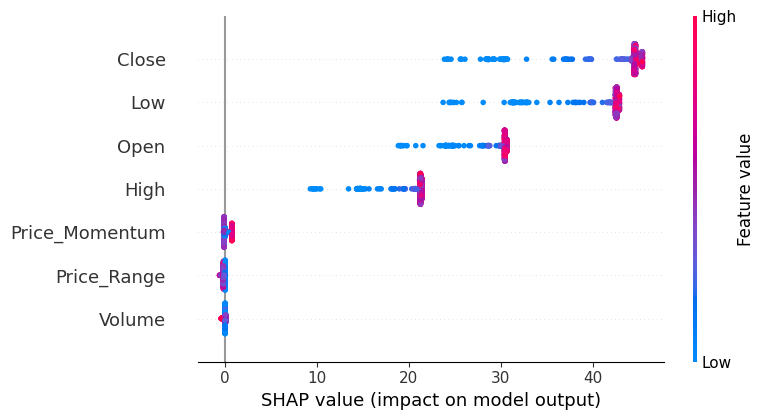

In [33]:
import shap


# Использование SHAP для случайного леса
explainer = shap.Explainer(model_forest, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


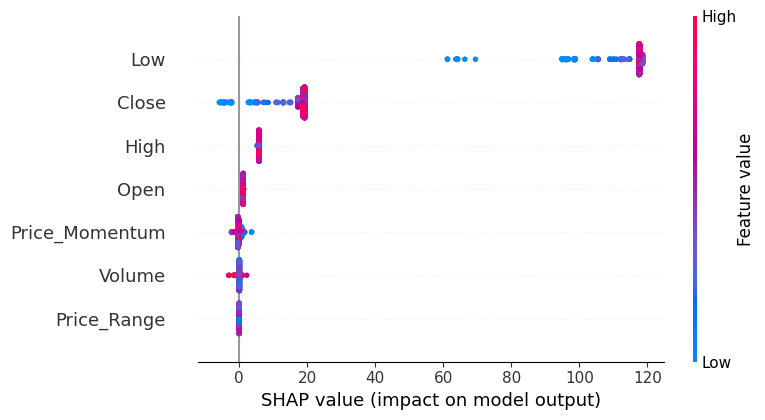

In [34]:
import shap

# Получаем модель из пайплайна
model = pipeline.named_steps['classifier']

# Для tree-based моделей лучше использовать TreeExplainer
explainer = shap.TreeExplainer(model)

# Получаем предобработанные данные
X_test_scaled = pipeline.named_steps['scaler'].transform(X_test)

# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_test_scaled)

# Визуализация
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

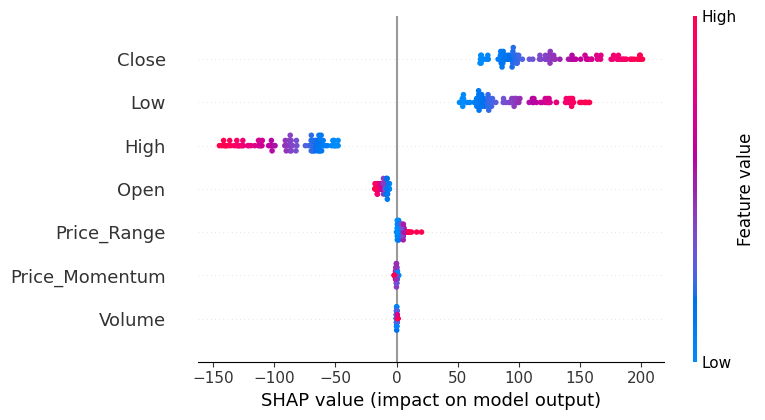

In [38]:
# Получаем лучшую модель
best_model = tpot.fitted_pipeline_

# Создаем функцию-обертку для предсказаний
def model_predict(X):
    return best_model.predict(X)

# Используем небольшую подвыборку для фона (для скорости)
background = shap.sample(X_train, 50)  # 50 samples for background

# Создаем explainer с использованием функции предсказания
explainer = shap.Explainer(model_predict, background)

# Вычисляем SHAP значения для тестовой выборки (можно взять подвыборку для скорости)
shap_values = explainer(X_test[:100])  # первые 100 samples

# Визуализируем результаты
shap.summary_plot(shap_values, X_test[:100])